<a href="https://colab.research.google.com/github/pa7003/E-Commerce-Analytics-/blob/main/E_Commerce_Analytics_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Upload your Kaggle API key (kaggle.json)
from google.colab import files
files.upload()  # Upload kaggle.json

# Move it to the correct location and set permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle
!kaggle datasets download -d olistbr/brazilian-ecommerce
!unzip brazilian-ecommerce.zip -d olist_data


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
License(s): CC-BY-NC-SA-4.0
  0% 0.00/42.6M [00:00<?, ?B/s]
100% 42.6M/42.6M [00:00<00:00, 1.32GB/s]
Archive:  brazilian-ecommerce.zip
  inflating: olist_data/olist_customers_dataset.csv  
  inflating: olist_data/olist_geolocation_dataset.csv  
  inflating: olist_data/olist_order_items_dataset.csv  
  inflating: olist_data/olist_order_payments_dataset.csv  
  inflating: olist_data/olist_order_reviews_dataset.csv  
  inflating: olist_data/olist_orders_dataset.csv  
  inflating: olist_data/olist_products_dataset.csv  
  inflating: olist_data/olist_sellers_dataset.csv  
  inflating: olist_data/product_category_name_translation.csv  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Load all Olist dataset files
path = "olist_data/"
customers = pd.read_csv(path + "olist_customers_dataset.csv")
orders = pd.read_csv(path + "olist_orders_dataset.csv")
order_items = pd.read_csv(path + "olist_order_items_dataset.csv")
order_payments = pd.read_csv(path + "olist_order_payments_dataset.csv")
order_reviews = pd.read_csv(path + "olist_order_reviews_dataset.csv")
products = pd.read_csv(path + "olist_products_dataset.csv")
sellers = pd.read_csv(path + "olist_sellers_dataset.csv")
geolocation = pd.read_csv(path + "olist_geolocation_dataset.csv")
category_translation = pd.read_csv(path + "product_category_name_translation.csv")


In [ ]:
# Check first few rows of orders dataset
orders.head()

# Check data types and missing values
orders.info()

# Check for missing data
orders.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


,0
order_id,0
customer_id,0
order_status,0
order_purchase_timestamp,0
order_approved_at,160
order_delivered_carrier_date,1783
order_delivered_customer_date,2965
order_estimated_delivery_date,0


# Data Cleaning and Preprocessing

In [ ]:
# Check first few rows of orders dataset
orders.head()

# Check data types and missing values
orders.info()

# Check for missing data
orders.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


,0
order_id,0
customer_id,0
order_status,0
order_purchase_timestamp,0
order_approved_at,160
order_delivered_carrier_date,1783
order_delivered_customer_date,2965
order_estimated_delivery_date,0


In [ ]:
# Checking for duplicates
duplicates = orders.duplicated().sum()

# Removing duplicates if found
orders = orders.drop_duplicates()

In [ ]:
# Check for missing values
missing_values = orders.isnull().sum()

# Impute or drop missing values
orders = orders.dropna()

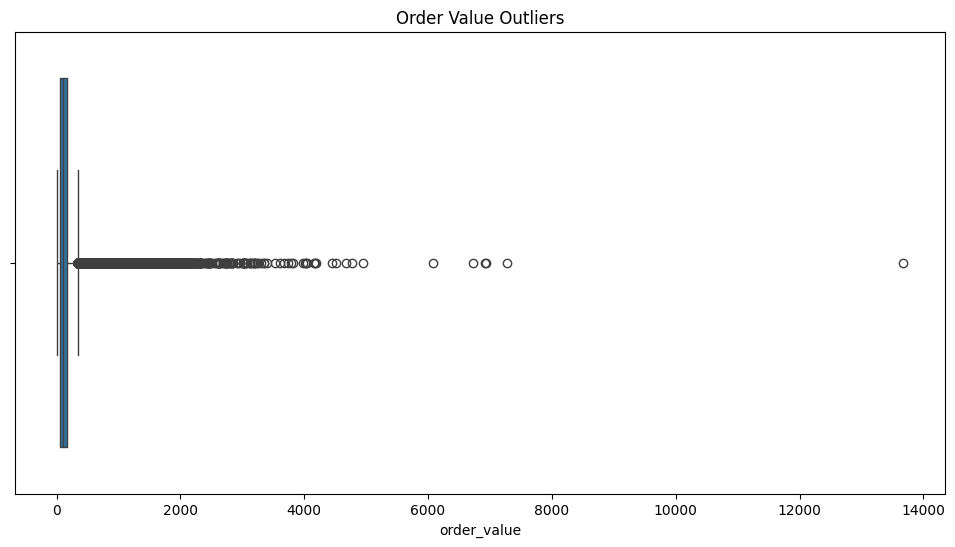

In [ ]:
# Calculate the total value for each order from order_items
# Group order_items by order_id and sum the price and freight_value
# Make sure order_items dataframe is loaded, which it is in the initial setup cells.
order_values = order_items.groupby('order_id')[['price', 'freight_value']].sum().reset_index()
order_values['order_value'] = order_values['price'] + order_values['freight_value']

# Merge the calculated order_values back into the orders DataFrame
# Use a left merge to keep all orders that were in the original 'orders' dataframe after cleaning
orders = pd.merge(orders, order_values[['order_id', 'order_value']], on='order_id', how='left')

# Drop rows where order_value could not be determined after the merge (should not be many if any)
orders = orders.dropna(subset=['order_value'])

# Boxplot to visualize outliers in order_value
plt.figure(figsize=(12,6))
sns.boxplot(x=orders['order_value'])
plt.title('Order Value Outliers')
plt.show()

# Removing outliers using IQR
Q1 = orders['order_value'].quantile(0.25)
Q3 = orders['order_value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

orders_no_outliers = orders[(orders['order_value'] >= lower_bound) & (orders['order_value'] <= upper_bound)]

In [ ]:
# Check for unique values in order_status
orders['order_status'].unique()

# Clean categorical variables if necessary
orders['order_status'] = orders['order_status'].replace({'canceled': 'Cancelled'})


In [ ]:
# Create 'days_since_last_purchase' feature based on order_date and customer_id
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['days_since_last_purchase'] = (orders['order_purchase_timestamp'].max() - orders['order_purchase_timestamp']).dt.days


# Exploratory Data Analysis

## 1. Sales Distribution

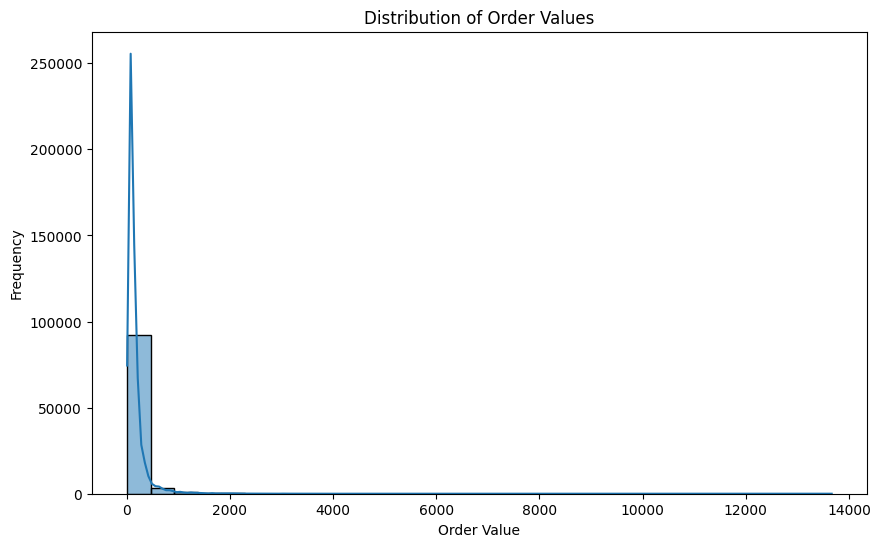

In [ ]:
# Distribution of Order Values
plt.figure(figsize=(10, 6))
sns.histplot(orders['order_value'], bins=30, kde=True)
plt.title('Distribution of Order Values')
plt.xlabel('Order Value')
plt.ylabel('Frequency')
plt.show()


## 2. Boxplot for Order Value Outliers

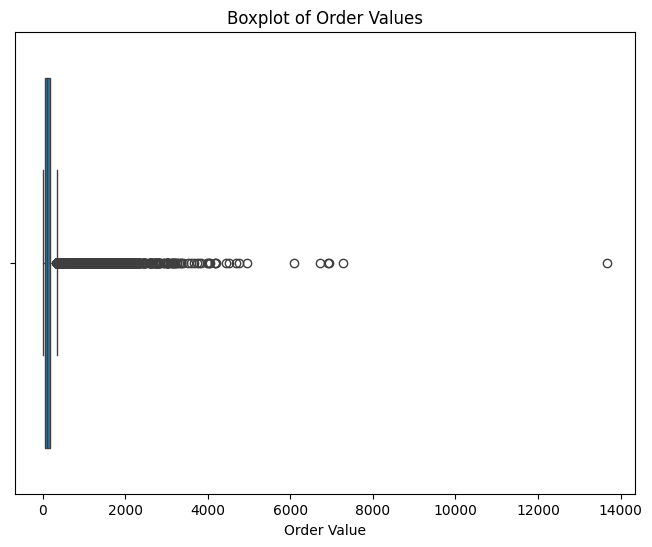

In [ ]:
# Boxplot of Order Values
plt.figure(figsize=(8, 6))
sns.boxplot(x=orders['order_value'])
plt.title('Boxplot of Order Values')
plt.xlabel('Order Value')
plt.show()


## 3: Order Counts Over Time

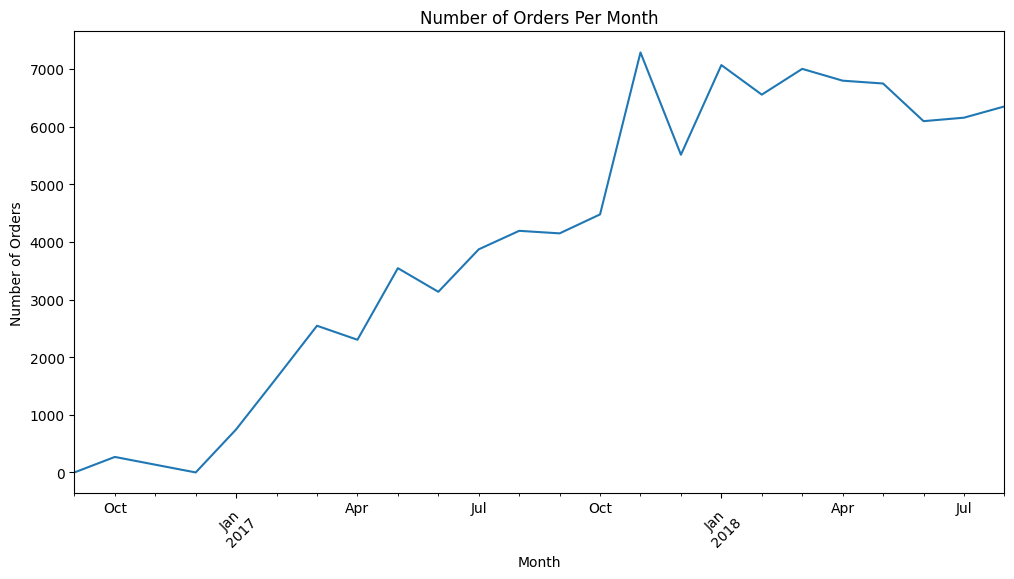

In [ ]:
# Extract Month and Year
orders['purchase_month'] = orders['order_purchase_timestamp'].dt.to_period('M')

# Count Orders by Month
order_counts = orders.groupby('purchase_month').size()

# Plotting Orders by Month
plt.figure(figsize=(12, 6))
order_counts.plot(kind='line')
plt.title('Number of Orders Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()


## 4: Order Status Distribution

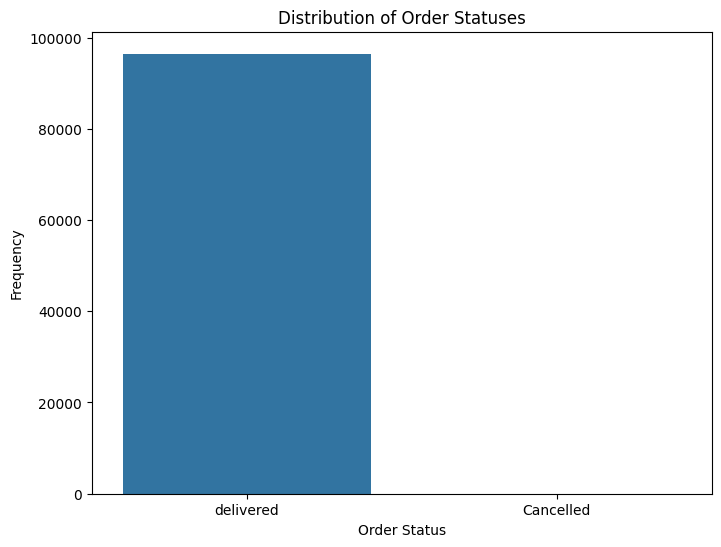

In [ ]:
# Count of Order Statuses
order_status_counts = orders['order_status'].value_counts()

# Bar Plot of Order Statuses
plt.figure(figsize=(8, 6))
sns.barplot(x=order_status_counts.index, y=order_status_counts.values)
plt.title('Distribution of Order Statuses')
plt.xlabel('Order Status')
plt.ylabel('Frequency')
plt.show()


## 5: Delivery Time Distribution

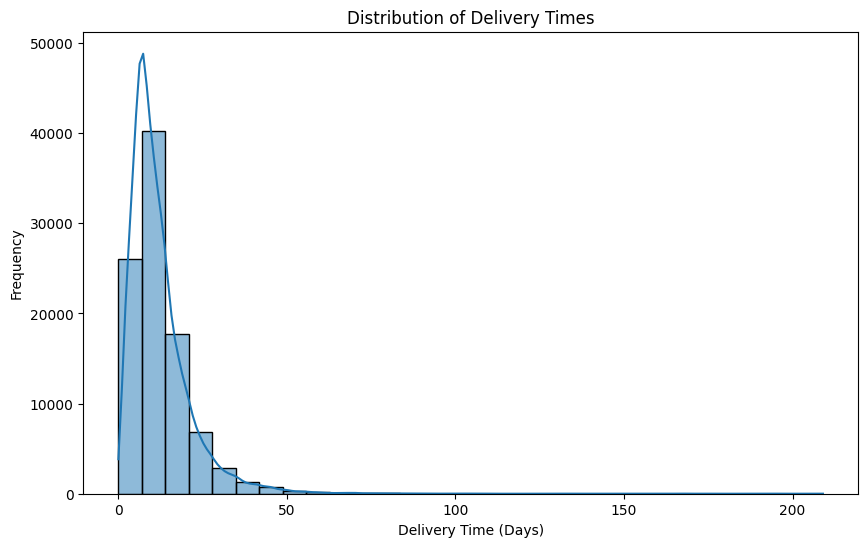

In [ ]:
# Calculate Delivery Time in Days
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['delivery_time_days'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days

# Distribution of Delivery Times
plt.figure(figsize=(10, 6))
sns.histplot(orders['delivery_time_days'], bins=30, kde=True)
plt.title('Distribution of Delivery Times')
plt.xlabel('Delivery Time (Days)')
plt.ylabel('Frequency')
plt.show()

## 6: Days Since Last Purchase

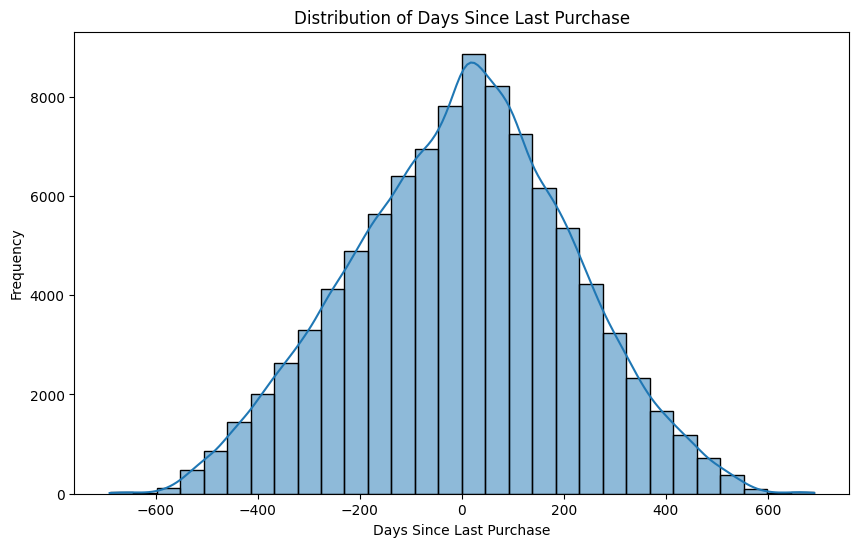

In [ ]:
# Days Since Last Purchase
orders['days_since_last_purchase'] = (orders['order_purchase_timestamp'] - orders['order_purchase_timestamp'].shift(1)).dt.days

# Distribution of Days Since Last Purchase
plt.figure(figsize=(10, 6))
sns.histplot(orders['days_since_last_purchase'], bins=30, kde=True)
plt.title('Distribution of Days Since Last Purchase')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Frequency')
plt.show()


## 7: Correlation Heatmap

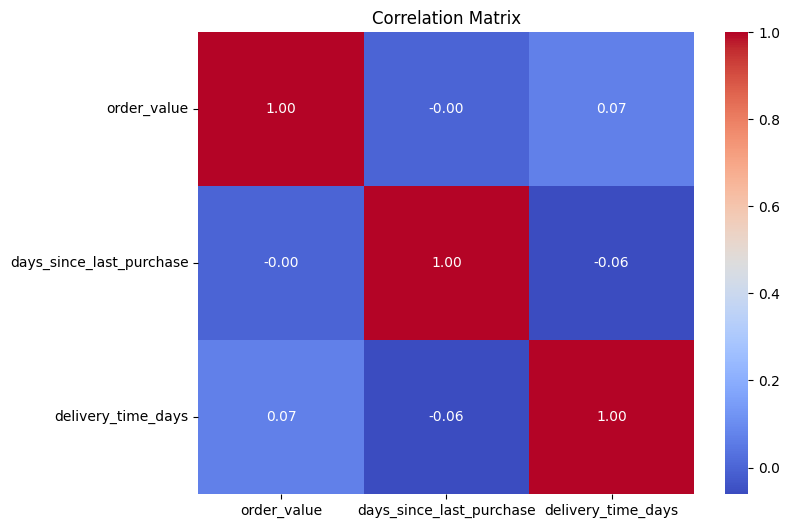

In [ ]:
# Correlation Matrix
corr_matrix = orders[['order_value', 'days_since_last_purchase', 'delivery_time_days']].corr()

# Plot Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


## 8: Customer Purchase Behavior

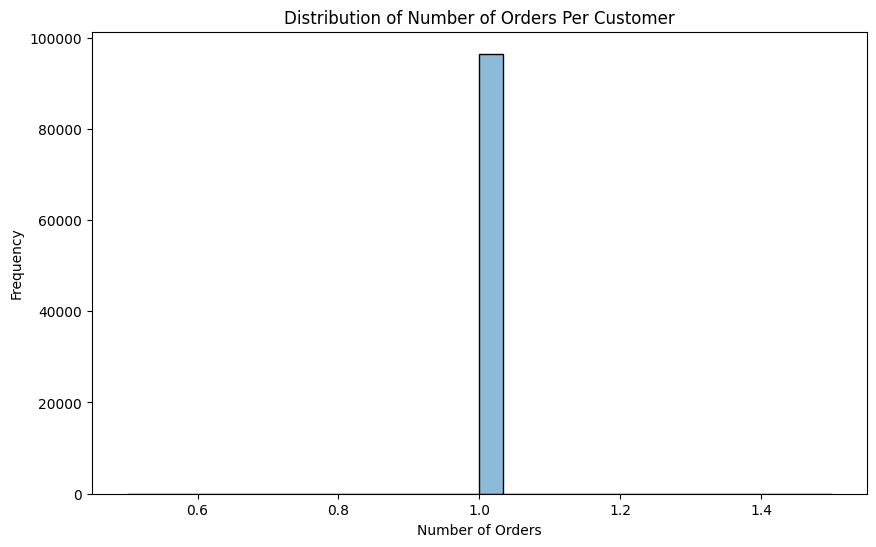

In [ ]:
# Number of Orders Per Customer
customer_order_counts = orders.groupby('customer_id')['order_id'].count()

# Distribution of Number of Orders per Customer
plt.figure(figsize=(10, 6))
sns.histplot(customer_order_counts, bins=30, kde=True)
plt.title('Distribution of Number of Orders Per Customer')
plt.xlabel('Number of Orders')
plt.ylabel('Frequency')
plt.show()


## 9: Delivery Time vs. Order Value

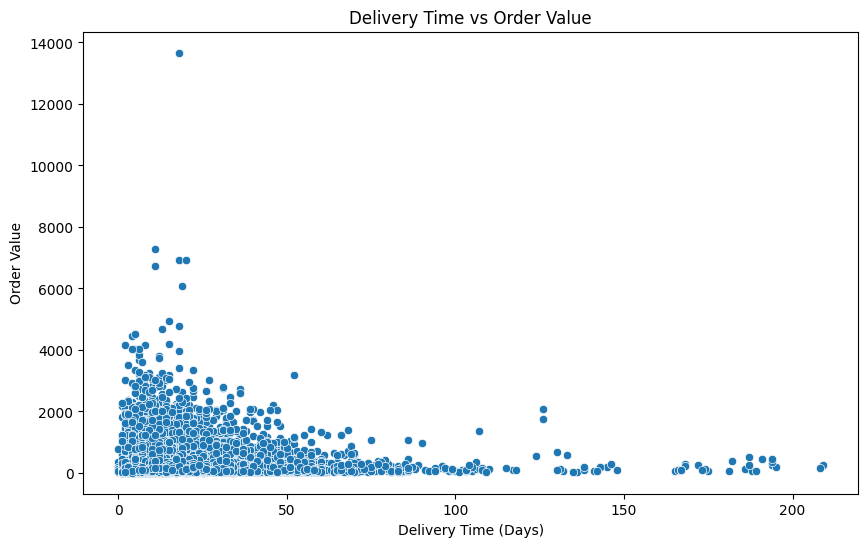

In [ ]:
# Scatter Plot of Delivery Time vs Order Value
plt.figure(figsize=(10, 6))
sns.scatterplot(x=orders['delivery_time_days'], y=orders['order_value'])
plt.title('Delivery Time vs Order Value')
plt.xlabel('Delivery Time (Days)')
plt.ylabel('Order Value')
plt.show()


## 10: Time to Delivery vs. Order Status

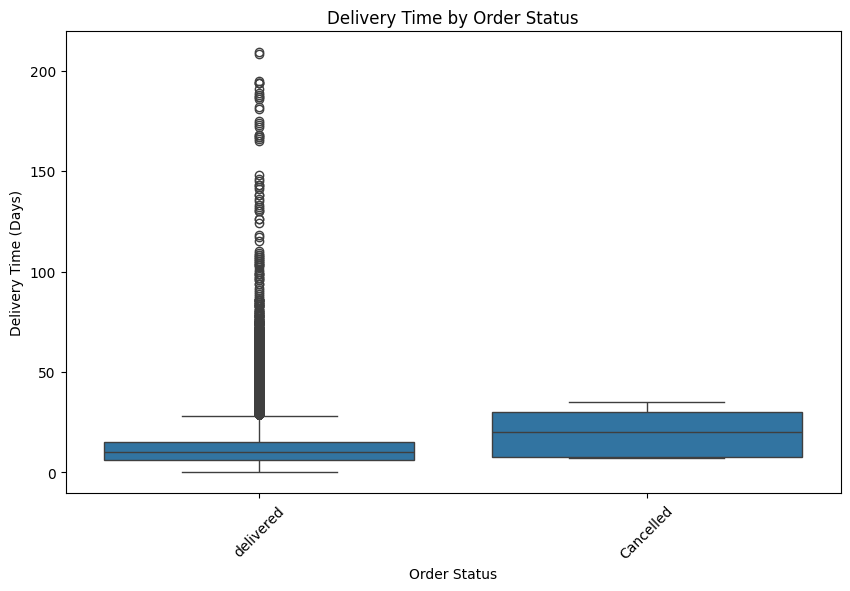

In [ ]:
# Boxplot of Delivery Time by Order Status
plt.figure(figsize=(10, 6))
sns.boxplot(x=orders['order_status'], y=orders['delivery_time_days'])
plt.title('Delivery Time by Order Status')
plt.xlabel('Order Status')
plt.ylabel('Delivery Time (Days)')
plt.xticks(rotation=45)
plt.show()


# Funnel Analysis

## Basic Funnel Analysis

Working with transactional data (order_id, order_status, etc.), we’ll define a simplified funnel using only order-related events:

1. Order Placed (order_purchase_timestamp is not null)

2. Order Approved (order_approved_at is not null)

3. Order Shipped (order_delivered_carrier_date is not null)

4. Order Delivered (order_delivered_customer_date is not null)


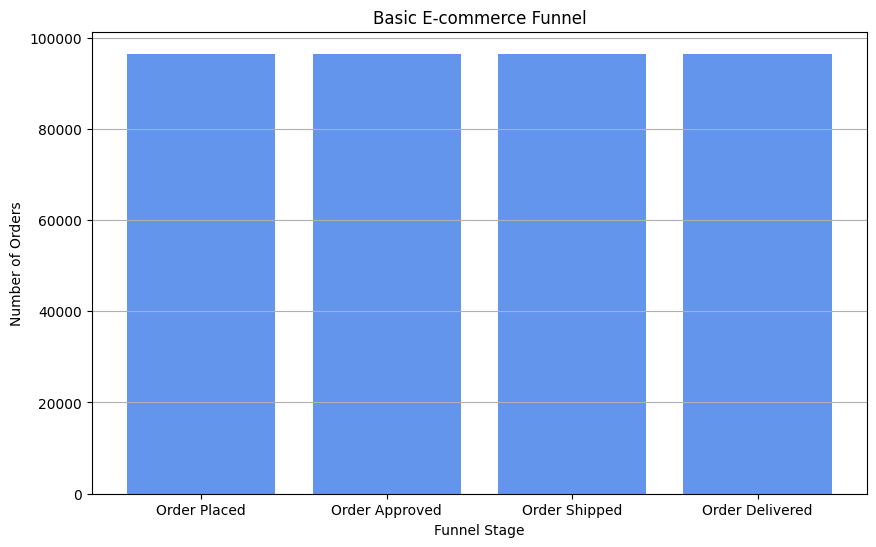

In [ ]:
# Load your dataset
import pandas as pd
import matplotlib.pyplot as plt

df = orders  # replace with your actual DataFrame

# Define funnel stages
funnel = {
    'Order Placed': df['order_purchase_timestamp'].notna().sum(),
    'Order Approved': df['order_approved_at'].notna().sum(),
    'Order Shipped': df['order_delivered_carrier_date'].notna().sum(),
    'Order Delivered': df['order_delivered_customer_date'].notna().sum(),
}

# Convert to DataFrame
funnel_df = pd.DataFrame(list(funnel.items()), columns=['Stage', 'Count'])

# Plot the funnel
plt.figure(figsize=(10, 6))
plt.bar(funnel_df['Stage'], funnel_df['Count'], color='cornflowerblue')
plt.title('Basic E-commerce Funnel')
plt.xlabel('Funnel Stage')
plt.ylabel('Number of Orders')
plt.grid(axis='y')
plt.show()


## 1. Percentage Drop-Off Between Each Stage

             Stage  Count  Drop-Off (%)
0     Order Placed  96461         100.0
1   Order Approved  96461         100.0
2    Order Shipped  96461         100.0
3  Order Delivered  96461         100.0


<ipython-input-22-de4fbf8d1946>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=funnel_df, x='Stage', y='Count', palette='Blues_d')


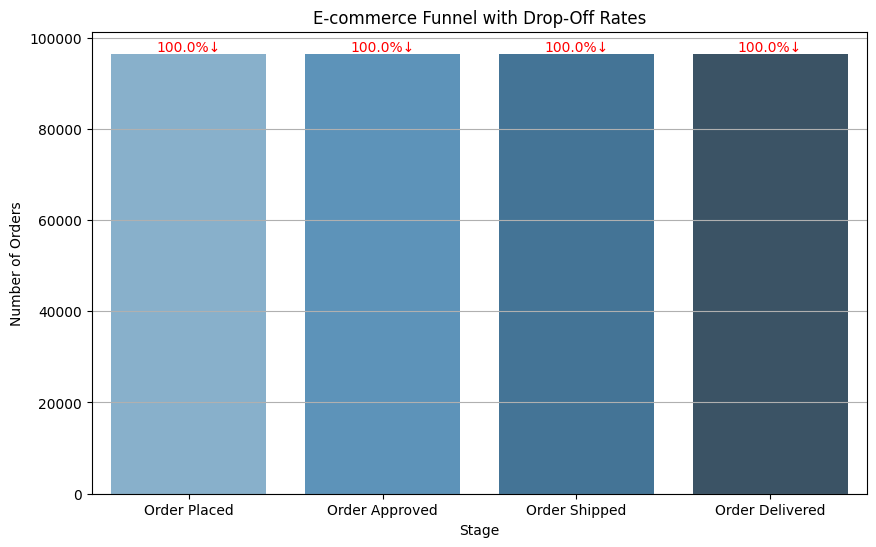

In [ ]:
# Calculate percentage drop between each stage
funnel_df['Drop-Off (%)'] = funnel_df['Count'].pct_change().fillna(0).apply(lambda x: round((1 - x) * 100, 2))

# Display updated funnel
print(funnel_df)

# Plot funnel with drop-off annotations
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=funnel_df, x='Stage', y='Count', palette='Blues_d')
for i, row in funnel_df.iterrows():
    plt.text(i, row['Count'] + 500, f"{row['Drop-Off (%)']}%↓", ha='center', fontsize=10, color='red')
plt.title("E-commerce Funnel with Drop-Off Rates")
plt.ylabel("Number of Orders")
plt.grid(axis='y')
plt.show()


## 2. Breakdown by Order Status (e.g., Canceled vs Delivered)

<ipython-input-23-3dab3a7b2fc5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.index, y=status_counts.values, palette='coolwarm')


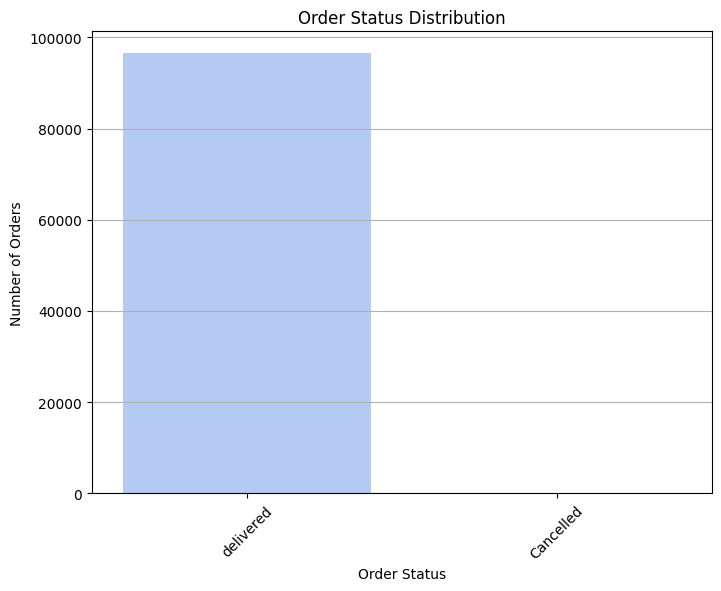

In [ ]:
# Count of orders by status
status_counts = df['order_status'].value_counts()

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=status_counts.index, y=status_counts.values, palette='coolwarm')
plt.title('Order Status Distribution')
plt.xlabel('Order Status')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


## 3. Weekly / Monthly Funnel Trends

### 3(i). 3. Weekly / Monthly Funnel Trends

In [ ]:
df['order_purchase_date'] = pd.to_datetime(df['order_purchase_timestamp'])
df['purchase_month'] = df['order_purchase_date'].dt.to_period('M')
df['purchase_week'] = df['order_purchase_date'].dt.isocalendar().week


### 3(ii). Monthly Trend of Order Statuses

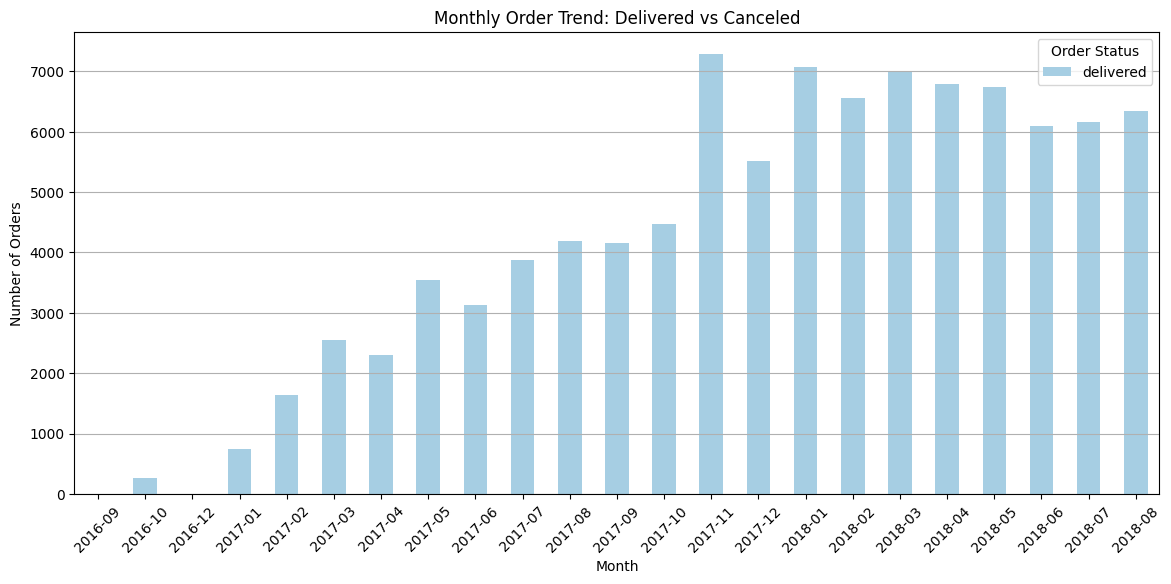

In [ ]:
# Monthly trend: Delivered vs Canceled
monthly_status = df[df['order_status'].isin(['delivered', 'canceled'])].groupby(['purchase_month', 'order_status']).size().unstack()

monthly_status.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='Paired')
plt.title("Monthly Order Trend: Delivered vs Canceled")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.legend(title='Order Status')
plt.grid(axis='y')
plt.show()


### 3(iii). Weekly Funnel Completion (Placed → Delivered)

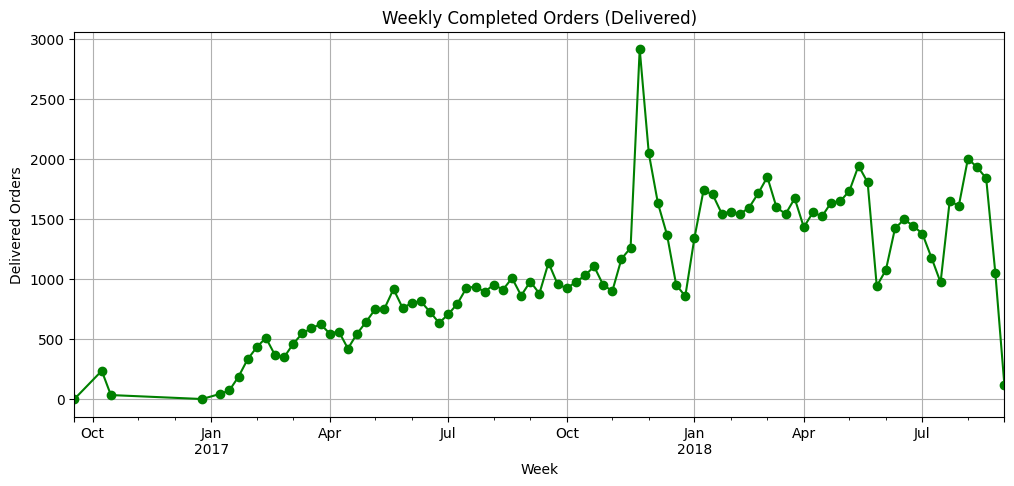

In [ ]:
# Weekly analysis of delivered orders
weekly_orders = df[df['order_delivered_customer_date'].notna()].groupby(df['order_purchase_date'].dt.to_period('W')).size()

weekly_orders.plot(kind='line', marker='o', figsize=(12, 5), color='green')
plt.title("Weekly Completed Orders (Delivered)")
plt.xlabel("Week")
plt.ylabel("Delivered Orders")
plt.grid(True)
plt.show()


# Intermediate Funnel Analysis

## 1. Segment Funnel: New vs Returning Customers

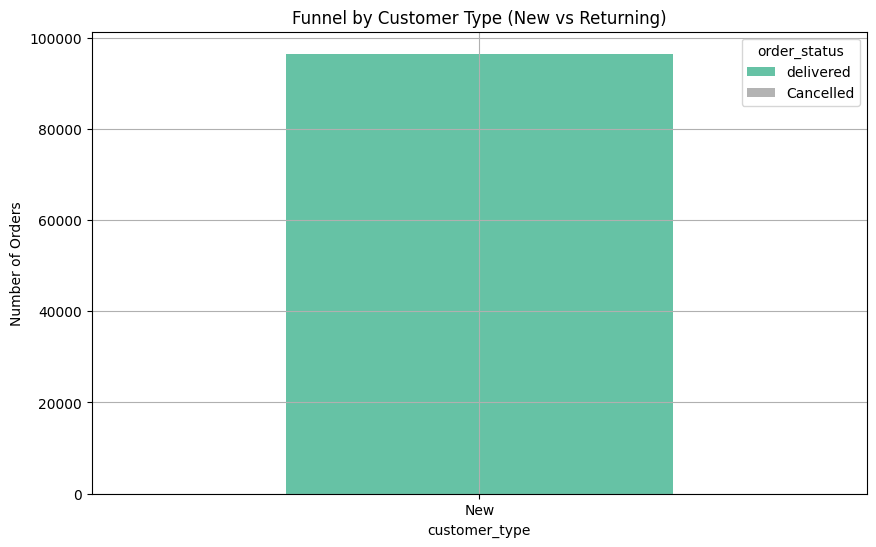

In [ ]:
# Check number of orders per customer
order_counts = df.groupby('customer_id')['order_id'].count()

# Tag customers as New or Returning
df['customer_type'] = df['customer_id'].map(lambda x: 'Returning' if order_counts[x] > 1 else 'New')

# Funnel by customer type
funnel_by_type = df.groupby(['customer_type', 'order_status']).size().unstack().fillna(0)

# Plot
# Use the corrected column name 'Cancelled' instead of 'canceled'
funnel_by_type[['delivered', 'Cancelled']].plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set2')
plt.title('Funnel by Customer Type (New vs Returning)')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.xticks(rotation=0)
plt.show()

## 2. Funnel by Geographic Region

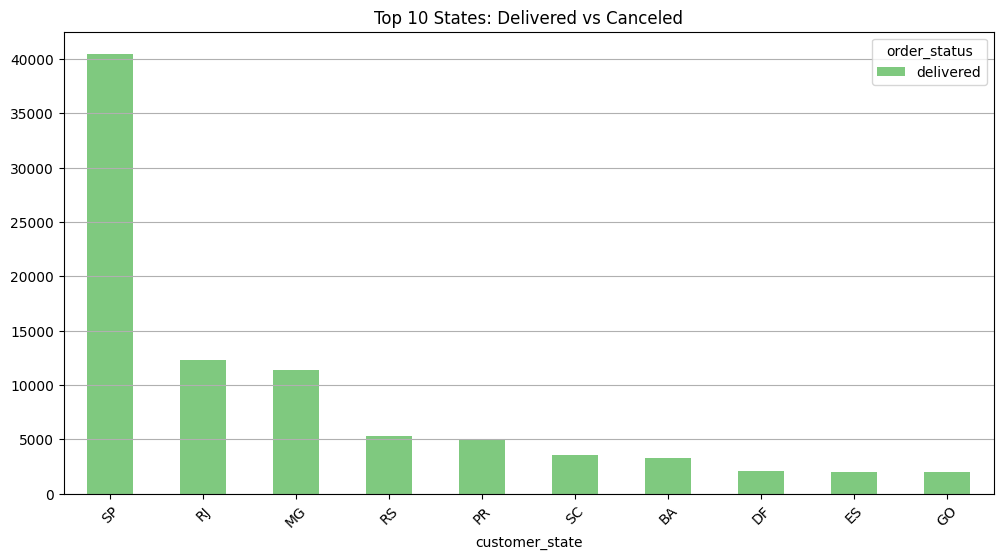

In [ ]:
df_merged = pd.merge(df, customers[['customer_id', 'customer_state']], on='customer_id', how='left')

# Now, group by 'customer_state' on the merged DataFrame
state_funnel = df_merged[df_merged['order_status'].isin(['delivered', 'canceled'])].groupby(['customer_state', 'order_status']).size().unstack()

top_states = state_funnel.sum(axis=1).sort_values(ascending=False).head(10)
state_funnel.loc[top_states.index].plot(kind='bar', stacked=True, figsize=(12,6), colormap='Accent')
plt.title('Top 10 States: Delivered vs Canceled')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

## 3. Funnel Completion Time

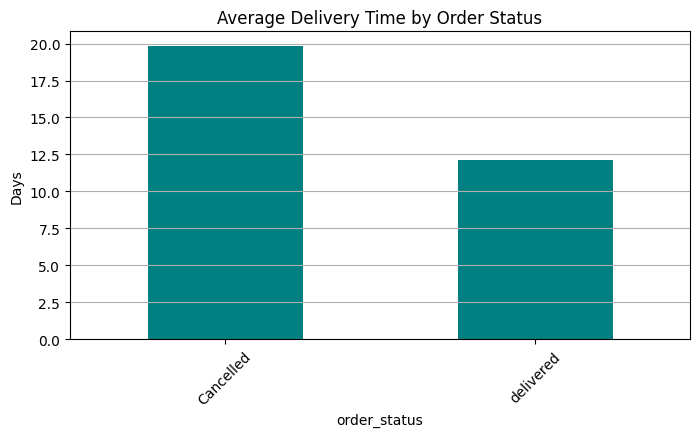

In [ ]:
# Calculate delivery time (in days)
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

df['delivery_time_days'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

# Average delivery time by order_status
avg_delivery_time = df.groupby('order_status')['delivery_time_days'].mean().dropna()

# Plot
avg_delivery_time.plot(kind='bar', color='teal', figsize=(8,4))
plt.title("Average Delivery Time by Order Status")
plt.ylabel("Days")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()


## 4. Monthly Funnel Trends (Normalized % Conversion)

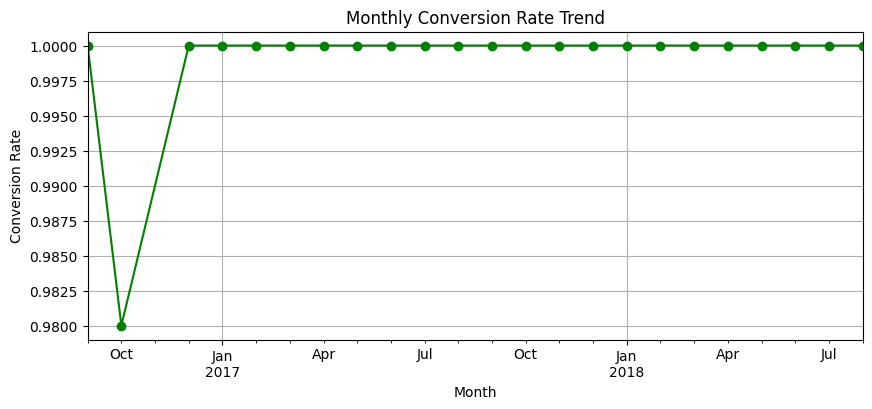

In [ ]:
monthly_funnel = df.groupby(['purchase_month', 'order_status']).size().unstack().fillna(0)
monthly_funnel['conversion_rate'] = (monthly_funnel['delivered'] / monthly_funnel.sum(axis=1)).round(2)

# Plot
monthly_funnel['conversion_rate'].plot(marker='o', color='green', figsize=(10,4))
plt.title('Monthly Conversion Rate Trend')
plt.ylabel('Conversion Rate')
plt.xlabel('Month')
plt.grid(True)
plt.show()


# Advanced Funnel Analysis

## 5. RFM-Based Funnel Insights

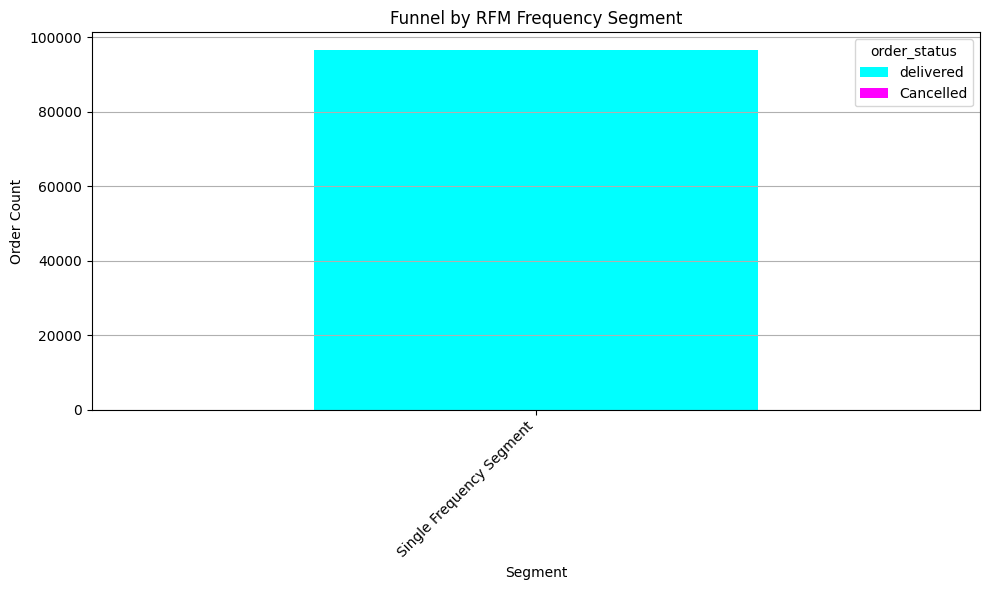

In [ ]:
# RFM Calculation
now = df['order_purchase_timestamp'].max()
rfm = df.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (now - x.max()).days,
    'order_id': 'count',
    'order_value': 'sum'
}).rename(columns={'order_purchase_timestamp': 'Recency', 'order_id': 'Frequency', 'order_value': 'Monetary'})

# Segment customers by Frequency
unique_frequencies = rfm['Frequency'].nunique()

if unique_frequencies <= 1:
    # If all frequencies are the same or there's only one customer, assign a single segment
    rfm['Segment'] = 'Single Frequency Segment'
elif unique_frequencies == 2:
    # If there are only two unique frequency values
    rfm['Segment'] = pd.qcut(rfm['Frequency'], q=2, labels=['Low Freq', 'High Freq'], duplicates='drop')
else:
    # If there are 3 or more unique frequency values, attempt to create 3 bins
    try:
        rfm['Segment'] = pd.qcut(rfm['Frequency'], q=3, labels=['Low Freq', 'Mid Freq', 'High Freq'], duplicates='drop')
    except ValueError:
        # Fallback if qcut still fails with 3 bins (e.g., very skewed data)
        # This might happen even with duplicates='drop' for complex distributions
        print("Could not create 3 distinct frequency bins. Falling back to simpler segmentation.")
        rfm['Segment'] = pd.qcut(rfm['Frequency'], q=2, labels=['Low Freq', 'High Freq'], duplicates='drop')


# Merge with main df
# Ensure the merge key 'customer_id' is present in both dataframes and is the index of rfm
df_rfm = df.merge(rfm[['Segment']], left_on='customer_id', right_index=True)

# Funnel by Segment
# Filter for relevant order statuses before grouping
# Use 'Cancelled' as the status was previously cleaned to this value
segment_funnel = df_rfm[df_rfm['order_status'].isin(['delivered', 'Cancelled'])].groupby(['Segment', 'order_status']).size().unstack().fillna(0)

# Plot
# Ensure the column names in the plot match the ones in segment_funnel after filtering and unstacking
# Define the desired order of segments for plotting
desired_segment_order = ['Single Frequency Segment', 'Low Freq', 'Mid Freq', 'High Freq']
# Filter and reindex segment_funnel based on the desired order and existing segments
existing_segments = [seg for seg in desired_segment_order if seg in segment_funnel.index]
segment_funnel = segment_funnel.reindex(existing_segments)

# Check if the necessary columns ('delivered', 'Cancelled') exist before plotting
cols_to_plot = [col for col in ['delivered', 'Cancelled'] if col in segment_funnel.columns]

if cols_to_plot:
    segment_funnel[cols_to_plot].plot(kind='bar', stacked=True, colormap='cool', figsize=(10,6))
    plt.title("Funnel by RFM Frequency Segment")
    plt.grid(axis='y')
    plt.ylabel("Order Count")
    plt.xticks(rotation=45, ha='right') # Improve label readability
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()
else:
    print("Could not plot segment funnel: 'delivered' or 'Cancelled' status not found in the filtered data.")

## 6. Cohort-Based Funnel Completion

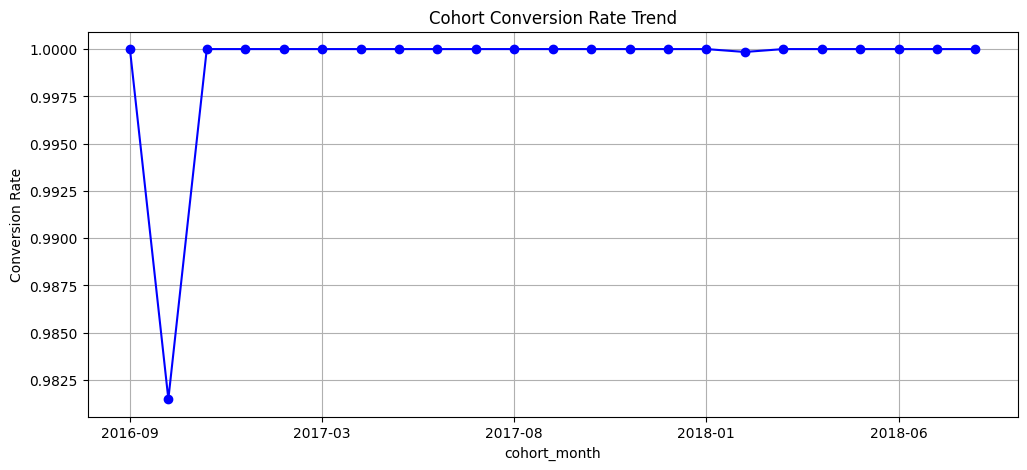

In [ ]:
# Filter for relevant order statuses before grouping. Use the cleaned status 'Cancelled'.
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])


df['cohort_month'] = df['order_purchase_timestamp'].dt.to_period('M').astype(str)


cohort_funnel = df[df['order_status'].isin(['delivered', 'Cancelled'])].groupby(['cohort_month', 'order_status']).size().unstack().fillna(0)


if 'delivered' in cohort_funnel.columns and 'Cancelled' in cohort_funnel.columns:
    # Calculate the total count for each cohort to get the denominator
    cohort_funnel['total_orders'] = cohort_funnel['delivered'] + cohort_funnel['Cancelled']

    # Calculate the conversion rate as delivered / total orders
    # Add a small epsilon or check for zero to avoid division by zero if a cohort has no orders
    cohort_funnel['conversion_rate'] = cohort_funnel['delivered'] / cohort_funnel['total_orders'].replace(0, np.nan)

    # Drop the 'total_orders' column if it's no longer needed for the plot
    cohort_funnel = cohort_funnel.drop(columns=['total_orders'])

    # Plotting the conversion rate, handling potential NaNs from division by zero
    cohort_funnel['conversion_rate'].dropna().plot(kind='line', marker='o', figsize=(12,5), color='blue')
    plt.title('Cohort Conversion Rate Trend')
    plt.ylabel('Conversion Rate')
    plt.grid(True)
    plt.show()
else:
    print("Could not calculate conversion rate: 'delivered' or 'Cancelled' status not found in cohort funnel data.")

## 7. Predictive Drop-Off Funnel (Classification Model) do

Build a binary classification model to predict order conversion outcome:

Target: 1 = delivered, 0 = canceled

Goal: Predict whether an order will drop off or complete successfully.

### 1. Prepare the Dataset

In [ ]:
# Filter for relevant statuses only
df_model = df[df['order_status'].isin(['delivered', 'canceled'])].copy()

# Encode target
df_model['delivered_flag'] = df_model['order_status'].apply(lambda x: 1 if x == 'delivered' else 0)


### 2. Select Features for Modeling
We'll use:

order_value

days_since_last_purchase

delivery_time_days

customer_type (encoded)



In [ ]:
# Create delivery time if not already
df_model['delivery_time_days'] = (pd.to_datetime(df_model['order_delivered_customer_date']) - pd.to_datetime(df_model['order_purchase_timestamp'])).dt.days

# Encode categorical feature
df_model['is_returning'] = df_model['customer_type'].apply(lambda x: 1 if x == 'Returning' else 0)

# Final feature set
features = ['order_value', 'days_since_last_purchase', 'delivery_time_days', 'is_returning']
X = df_model[features]
y = df_model['delivered_flag']


### 3. Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


### 4. Train a Classification Model (Logistic Regression / XGBoost)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

# Prepare the Dataset and Select Features (Assuming previous steps created df_model, features, X, y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check for missing values in the feature set before imputation
print("Missing values in features before imputation:")
print(X_train.isnull().sum()) # Check training set for NaNs

# Impute missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Fit the imputer on the training data and transform both training and testing data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Convert imputed arrays back to DataFrames with original column names for clarity (optional but good practice)
X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=features)
X_test_imputed_df = pd.DataFrame(X_test_imputed, columns=features)


Missing values in features before imputation:
order_value                 0
days_since_last_purchase    1
delivery_time_days          0
is_returning                0
dtype: int64


XGBoost Classifier (Better Performance)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96461 entries, 0 to 96460
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96461 non-null  object        
 1   customer_id                    96461 non-null  object        
 2   order_status                   96461 non-null  object        
 3   order_purchase_timestamp       96461 non-null  datetime64[ns]
 4   order_approved_at              96461 non-null  object        
 5   order_delivered_carrier_date   96461 non-null  object        
 6   order_delivered_customer_date  96461 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96461 non-null  object        
 8   order_value                    96461 non-null  float64       
 9   days_since_last_purchase       96460 non-null  float64       
 10  purchase_month                 96461 non-null  period[M]     
 11  delivery_time_d

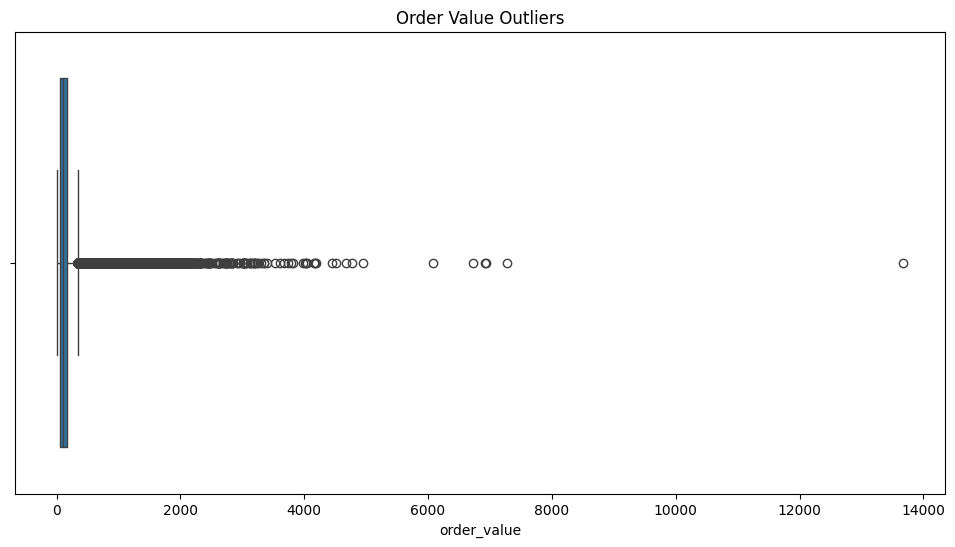


Unique order statuses after outlier removal (if applied to 'orders'):
['delivered' 'Cancelled']

Distribution of order_status in df_model BEFORE encoding and split:
order_status
delivered    96455
Cancelled        6
Name: count, dtype: int64

Distribution of 'delivered_flag' in df_model AFTER encoding:
delivered_flag
1    96455
0        6
Name: count, dtype: int64

Missing values in features BEFORE imputation (after split):
order_value            0
days_since_purchase    0
delivery_time_days     0
is_returning           0
dtype: int64

Training XGBoost with imputed data...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:09:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[    0     1]
 [    0 19292]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      1.00      1.00     19292

    accuracy                           1.00     19293
   macro avg       0.50      0.50      0.50     19293
weighted avg       1.00      1.00      1.00     19293

ROC-AUC: 0.9872


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


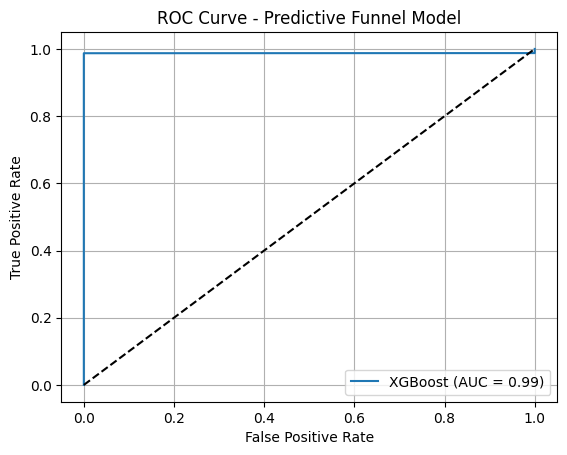

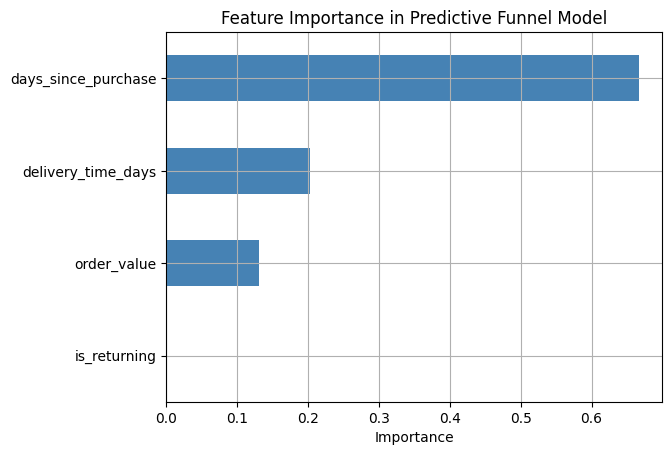

In [ ]:
# Check first few rows of orders dataset
orders.head()

# Check data types and missing values
orders.info()

# Check for missing data
print("Missing values before dropna():")
print(orders.isnull().sum())


orders = orders.dropna(subset=['order_status'])

print("\nMissing values after dropping rows with missing 'order_status' (if any):")
print(orders.isnull().sum())

# Add a check for order status distribution after this cleaning step
print("\nOrder status distribution after cleaning:")
print(orders['order_status'].value_counts())


order_values = order_items.groupby('order_id')[['price', 'freight_value']].sum().reset_index()
order_values['order_value'] = order_values['price'] + order_values['freight_value']

if 'order_value' not in orders.columns:
    orders = pd.merge(orders, order_values[['order_id', 'order_value']], on='order_id', how='left')
else:
    print("Info: 'order_value' column already exists in orders. Skipping merge.")

if 'order_value' in orders.columns:
    orders = orders.dropna(subset=['order_value'])
else:
     print("Warning: 'order_value' column not found after merge/skip. Cannot drop NaNs based on it.")


# Boxplot to visualize outliers in order_value
# Add a check before plotting as well
if 'order_value' in orders.columns:
    plt.figure(figsize=(12,6))
    sns.boxplot(x=orders['order_value'])
    plt.title('Order Value Outliers')
    plt.show()
else:
    print("Could not plot Order Value Outliers: 'order_value' column not available.")


# Removing outliers using IQR
# Add a check before calculating quantiles
if 'order_value' in orders.columns:
    Q1 = orders['order_value'].quantile(0.25)
    Q3 = orders['order_value'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    orders_no_outliers = orders[(orders['order_value'] >= lower_bound) & (orders['order_value'] <= upper_bound)]
else:
     print("Could not calculate IQR and remove outliers: 'order_value' column not available.")


# Check for unique values in order_status
print("\nUnique order statuses after outlier removal (if applied to 'orders'):")
print(orders['order_status'].unique()) # Check the 'orders' DataFrame being used

# Clean categorical variables if necessary
# Ensure 'canceled' is consistently handled, as it was changed to 'Cancelled' later
orders['order_status'] = orders['order_status'].replace({'canceled': 'Cancelled'})

# Create 'days_since_last_purchase' feature based on order_date and customer_id
# Recalculate this on the current 'orders' DataFrame
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

latest_order_date = orders['order_purchase_timestamp'].max()
orders['days_since_purchase'] = (latest_order_date - orders['order_purchase_timestamp']).dt.days


df_model = orders[orders['order_status'].isin(['delivered', 'Cancelled'])].copy()

# Add a crucial check here: See the distribution of the target variable *before* splitting
print("\nDistribution of order_status in df_model BEFORE encoding and split:")
print(df_model['order_status'].value_counts())

# Encode target
df_model['delivered_flag'] = df_model['order_status'].apply(lambda x: 1 if x == 'delivered' else 0)

# Add another check: See the distribution of the target variable *after* encoding
print("\nDistribution of 'delivered_flag' in df_model AFTER encoding:")
print(df_model['delivered_flag'].value_counts())

# If the output of the last print statement shows counts for both 0 and 1,
# then the issue of having only one class in y_train should be resolved.

# Select Features for Modeling
# Use the corrected 'days_since_purchase' feature
features = ['order_value', 'days_since_purchase', 'delivery_time_days', 'is_returning']



df_model['order_delivered_customer_date'] = pd.to_datetime(df_model['order_delivered_customer_date']) # Ensure datetime
df_model['order_purchase_timestamp'] = pd.to_datetime(df_model['order_purchase_timestamp']) # Ensure datetime

df_model['delivery_time_days'] = (df_model['order_delivered_customer_date'] - df_model['order_purchase_timestamp']).dt.days


order_counts_model_df = df_model.groupby('customer_id')['order_id'].transform('count') # Calculate counts within df_model
df_model['customer_type'] = order_counts_model_df.apply(lambda x: 'Returning' if x > 1 else 'New')

df_model['is_returning'] = df_model['customer_type'].apply(lambda x: 1 if x == 'Returning' else 0)


X = df_model[features]
y = df_model['delivered_flag']

# Split data into training and testing sets
# This split will now use the 'y' which should contain both 0s and 1s
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check for missing values in the feature set before imputation
print("\nMissing values in features BEFORE imputation (after split):")
print(X_train.isnull().sum()) # Check training set for NaNs


imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Fit the imputer on the training data and transform both training and testing data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Convert imputed arrays back to DataFrames with original column names for clarity
X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=features)
X_test_imputed_df = pd.DataFrame(X_test_imputed, columns=features)

# Now use the imputed DataFrames for training
print("\nTraining XGBoost with imputed data...")
# Option B: XGBoost Classifier (Better Performance)
from xgboost import XGBClassifier

# Use the imputed training data
# Added 'objective' and 'n_estimators' for common use case, kept eval_metric
xgb = XGBClassifier(objective='binary:logistic', n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_imputed_df, y_train) # Use X_train_imputed_df here

# Predict using the imputed test data
y_pred_xgb = xgb.predict(X_test_imputed_df) # Use X_test_imputed_df here
y_proba_xgb = xgb.predict_proba(X_test_imputed_df)[:, 1] # Use X_test_imputed_df here

print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_xgb):.4f}")

# Visualize Results (using results from XGBoost)
# ROC Curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr, tpr, label='XGBoost (AUC = %.2f)' % roc_auc_score(y_test, y_proba_xgb))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Predictive Funnel Model')
plt.legend()
plt.grid()
plt.show()

# Feature Importance
import seaborn as sns
import pandas as pd

# Get feature importances from the trained xgb model
feat_imp = pd.Series(xgb.feature_importances_, index=features).sort_values()
feat_imp.plot(kind='barh', color='steelblue')
plt.title("Feature Importance in Predictive Funnel Model")
plt.xlabel("Importance")
plt.grid(True)
plt.show()

# A/B Testing Simulation

## Step 1: Define the Simulation Scenario
## Let’s simulate a marketing email campaign split into:

## Group A: Receives the original email

## Group B: Receives a new, redesigned email

## We’ll simulate which group each customer belongs to and whether they converted (i.e., placed an order) after the email.

## Step 2: Simulate A/B Groups and Conversions
We'll randomly assign users and simulate conversion outcomes.


In [ ]:

merged_df = pd.merge(orders, customers[['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']], on='customer_id', how='left')

# Make a copy of the customers/orders
ab_data = merged_df.copy()

# Drop duplicates to simulate unique users
ab_data = ab_data.drop_duplicates(subset='customer_unique_id')

# Random assignment to Group A or B
np.random.seed(42)
ab_data['Group'] = np.random.choice(['A', 'B'], size=len(ab_data), p=[0.5, 0.5])

# Simulate conversions: Group A has 12% conversion, Group B has 16%
ab_data['converted'] = ab_data.apply(
    lambda row: np.random.rand() < 0.12 if row['Group'] == 'A' else np.random.rand() < 0.16,
    axis=1
)

<ipython-input-38-60b202c40bf8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ab_data['Group'] = np.random.choice(['A', 'B'], size=len(ab_data), p=[0.5, 0.5])


## Step 3: Compare Conversion Rates

In [ ]:
conversion_summary = ab_data.groupby('Group')['converted'].agg(['mean', 'count', 'sum'])
conversion_summary.rename(columns={'mean': 'conversion_rate'}, inplace=True)
conversion_summary


,conversion_rate,count,sum
Group,,,
A,0.119977,46559,5586
B,0.158904,46783,7434


## Step 4: Statistical Significance Test (Chi-Square Test)

In [ ]:
from scipy.stats import chi2_contingency

# Create contingency table
contingency = pd.crosstab(ab_data['Group'], ab_data['converted'])

# Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi-square test p-value:", p)
if p < 0.05:
    print("Statistically significant difference between groups.")
else:
    print("No statistically significant difference.")


Chi-square test p-value: 5.83184690894688e-66
Statistically significant difference between groups.


## Step 5: Visualization of A/B Test Results

<ipython-input-41-07f771d49b4e>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=ab_data, x='Group', y='converted', ci=None)


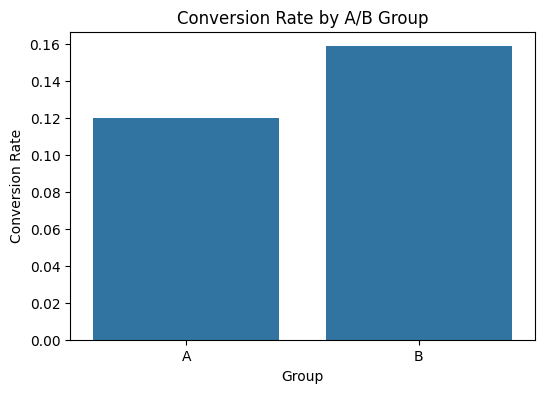

In [ ]:
plt.figure(figsize=(6, 4))
sns.barplot(data=ab_data, x='Group', y='converted', ci=None)
plt.title('Conversion Rate by A/B Group')
plt.ylabel('Conversion Rate')
plt.show()


# Comparing the effectiveness of Uplift Modeling vs. A/B Testing

##  1. Conversion Rate by Uplift Score Segment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 3.4 MB/s eta 0:00:00
Adding dummy 'uplift_score' for demonstration. Replace with a real model calculation.


<Figure size 1000x600 with 0 Axes>

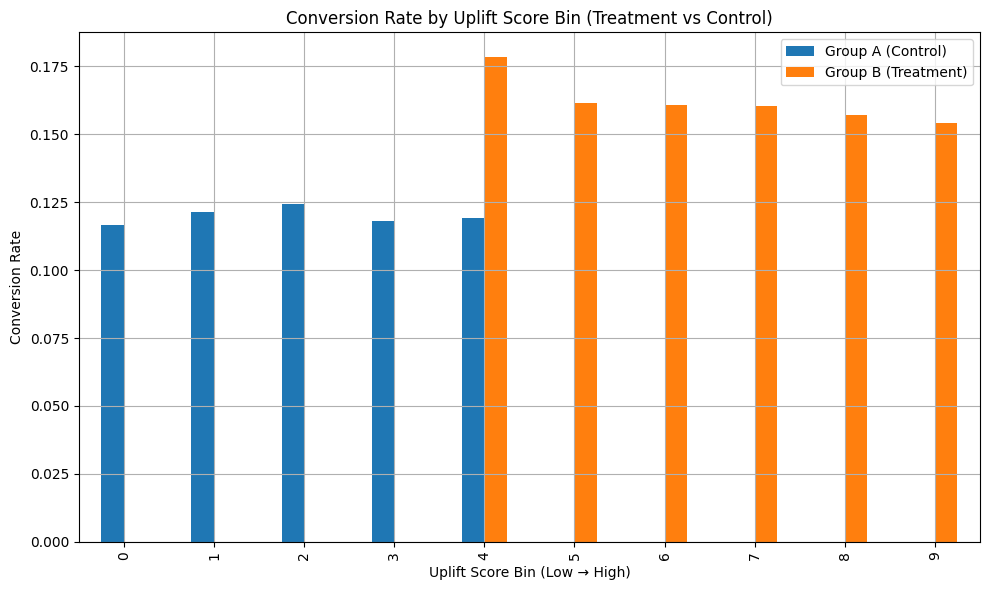

In [ ]:
!pip install scikit-uplift
# Install econml if you want to train a proper uplift model
# !pip install econml

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print("Adding dummy 'uplift_score' for demonstration. Replace with a real model calculation.")
np.random.seed(42) # for reproducibility
# Simulate some uplift scores that are slightly higher for Group B (treatment=1)
# A real model would calculate these based on features.
ab_data['uplift_score'] = ab_data.apply(
    lambda row: np.random.uniform(0.01, 0.05) if row['Group'] == 'A' else np.random.uniform(0.03, 0.08),
    axis=1
)

# Binning uplift scores into 10 equal-sized bins
# Use 'ab_data' instead of 'results'
ab_data['uplift_bin'] = pd.qcut(ab_data['uplift_score'], q=10, labels=False, duplicates='drop') # Added duplicates='drop'

# Group by bin and treatment to get average conversion
# Use 'ab_data' instead of 'results'
bin_summary = ab_data.groupby(['uplift_bin', 'Group'])['converted'].mean().unstack()

# Plot
plt.figure(figsize=(10,6))
# Use the correct column names from the 'Group' column ('A', 'B')
bin_summary.plot(kind='bar', figsize=(10,6))
plt.title('Conversion Rate by Uplift Score Bin (Treatment vs Control)')
plt.xlabel('Uplift Score Bin (Low → High)')
plt.ylabel('Conversion Rate')
# Ensure legend labels match your 'Group' column values ('A', 'B')
plt.legend(['Group A (Control)', 'Group B (Treatment)'])
plt.grid(True)
plt.tight_layout()
plt.show()

## 2. Qini Curve

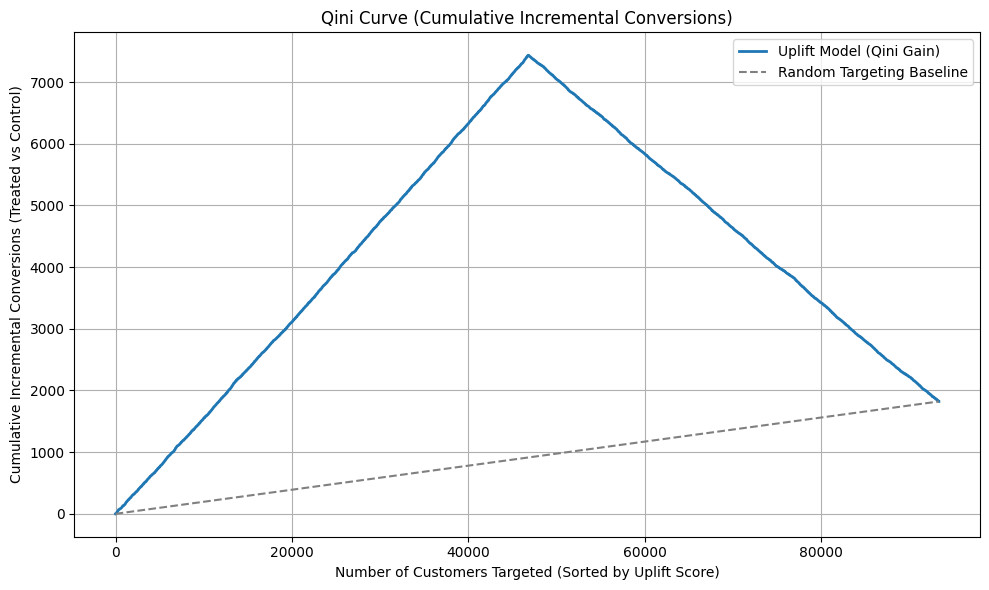

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df_qini = pd.DataFrame({
    # Encode the 'Group' column into a binary treatment variable (1 for Treatment B, 0 for Control A)
    'treatment': ab_data['Group'].apply(lambda x: 1 if x == 'B' else 0),
    # Use the simulated 'converted' outcome from the A/B test
    'y': ab_data['converted'],
    # Use the simulated 'uplift_score' from the A/B test
    'uplift_score': ab_data['uplift_score']
})

# Sort by uplift score descending
df_qini = df_qini.sort_values('uplift_score', ascending=False).reset_index(drop=True)

# Cumulative treated and control groups
df_qini['cumulative_treated'] = (df_qini['treatment'] == 1).cumsum()
df_qini['cumulative_control'] = (df_qini['treatment'] == 0).cumsum()

# Cumulative conversions
df_qini['cumulative_y_treated'] = ((df_qini['treatment'] == 1) & (df_qini['y'] == True)).cumsum() # Use boolean True for 'converted'
df_qini['cumulative_y_control'] = ((df_qini['treatment'] == 0) & (df_qini['y'] == True)).cumsum() # Use boolean True for 'converted'

# Compute Incremental Gain

# Avoid divide-by-zero by adding a small epsilon
epsilon = 1e-6

df_qini['uplift_gain'] = df_qini['cumulative_y_treated'] / (df_qini['cumulative_treated'] + epsilon) - \
                         df_qini['cumulative_y_control'] / (df_qini['cumulative_control'] + epsilon)


df_qini['customers_targeted'] = df_qini.index + 1

# Plot Qini Curve

total_treated_conversions = df_qini[df_qini['treatment'] == 1]['y'].sum()
total_treated_customers = (df_qini['treatment'] == 1).sum()
total_control_conversions = df_qini[df_qini['treatment'] == 0]['y'].sum()
total_control_customers = (df_qini['treatment'] == 0).sum()

# Ensure denominators are not zero
overall_treated_conversion_rate = total_treated_conversions / (total_treated_customers + epsilon)
overall_control_conversion_rate = total_control_conversions / (total_control_customers + epsilon)

# The baseline uplift rate difference is constant for random targeting
baseline_uplift_rate_difference = overall_treated_conversion_rate - overall_control_conversion_rate


df_qini['qini_gain'] = df_qini['cumulative_y_treated'] - df_qini['cumulative_y_control'] * (total_treated_customers / (total_control_customers + epsilon))

# Calculate random Qini gain
df_qini['random_qini_gain'] = df_qini['customers_targeted'] * (overall_treated_conversion_rate * (total_treated_customers / len(df_qini)) - overall_control_conversion_rate * (total_control_customers / len(df_qini)))


# Let's plot the standard Qini gain curve
plt.figure(figsize=(10, 6))
plt.plot(df_qini['customers_targeted'], df_qini['qini_gain'], label='Uplift Model (Qini Gain)', linewidth=2)


total_qini_gain = total_treated_conversions - total_control_conversions * (total_treated_customers / (total_control_customers + epsilon))
plt.plot([0, len(df_qini)], [0, total_qini_gain], '--', label='Random Targeting Baseline', color='gray')


plt.title('Qini Curve (Cumulative Incremental Conversions)')
plt.xlabel('Number of Customers Targeted (Sorted by Uplift Score)')
plt.ylabel('Cumulative Incremental Conversions (Treated vs Control)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Qini curve using simulated data

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:09:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:09:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


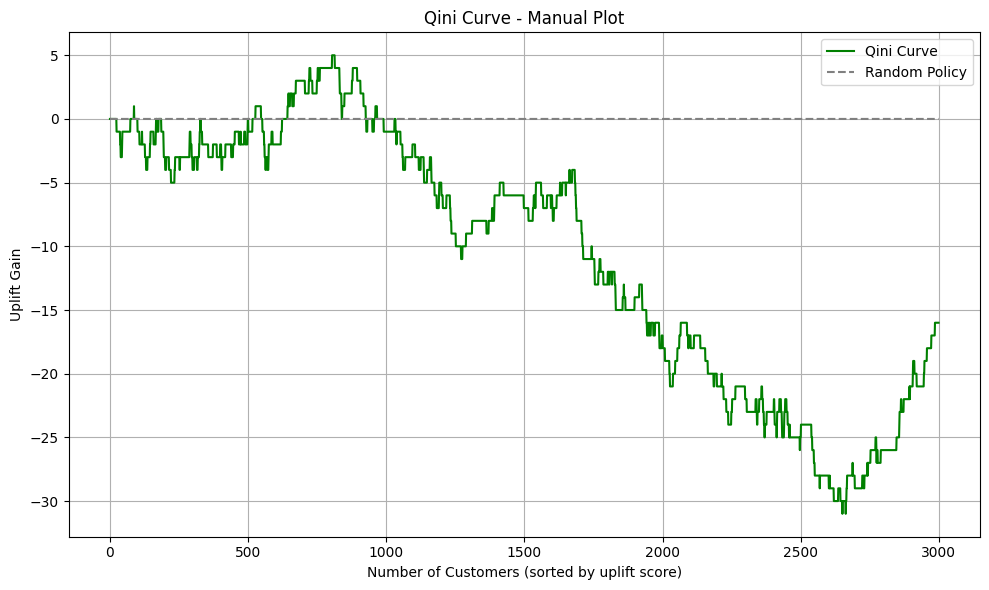

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# 1. Generate simulated data
np.random.seed(42)
n_samples = 10000

df = pd.DataFrame({
    'feature1': np.random.rand(n_samples),
    'feature2': np.random.randint(0, 100, n_samples),
    'y': np.random.binomial(1, 0.1, n_samples),  # 10% conversion rate
    'treatment': np.random.binomial(1, 0.5, n_samples)
})

X = df[['feature1', 'feature2']]
y = df['y']
treatment = df['treatment']

# 2. Train/test split
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    X, y, treatment, test_size=0.3, random_state=42
)

# 3. Train separate models
model_t = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_c = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

model_t.fit(X_train[treatment_train==1], y_train[treatment_train==1])
model_c.fit(X_train[treatment_train==0], y_train[treatment_train==0])

# 4. Predict uplift scores
p_t = model_t.predict_proba(X_test)[:, 1]
p_c = model_c.predict_proba(X_test)[:, 1]
uplift_scores = p_t - p_c

# 5. Prepare Qini curve values
qini_df = pd.DataFrame({
    'uplift': uplift_scores,
    'treatment': treatment_test.values,
    'y': y_test.values
})

qini_df.sort_values(by='uplift', ascending=False, inplace=True)
qini_df.reset_index(drop=True, inplace=True)

# 6. Compute cumulative gain for treatment & control
qini_df['cumulative_treatment'] = (qini_df['treatment'] * qini_df['y']).cumsum()
qini_df['cumulative_control'] = ((1 - qini_df['treatment']) * qini_df['y']).cumsum()
qini_df['uplift_gain'] = qini_df['cumulative_treatment'] - qini_df['cumulative_control']

# 7. Plot the Qini curve
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(qini_df)), qini_df['uplift_gain'], label='Qini Curve', color='green')
plt.plot(np.arange(len(qini_df)), np.zeros_like(qini_df['uplift_gain']), linestyle='--', color='gray', label='Random Policy')
plt.xlabel('Number of Customers (sorted by uplift score)')
plt.ylabel('Uplift Gain')
plt.title('Qini Curve - Manual Plot')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Qini curve plotting using E-commerce dataset.

<ipython-input-45-f06ef544e083>:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'order_purchase_timestamp': pd.date_range(start='2022-01-01', periods=n_samples, freq='H'),
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:09:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:09:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


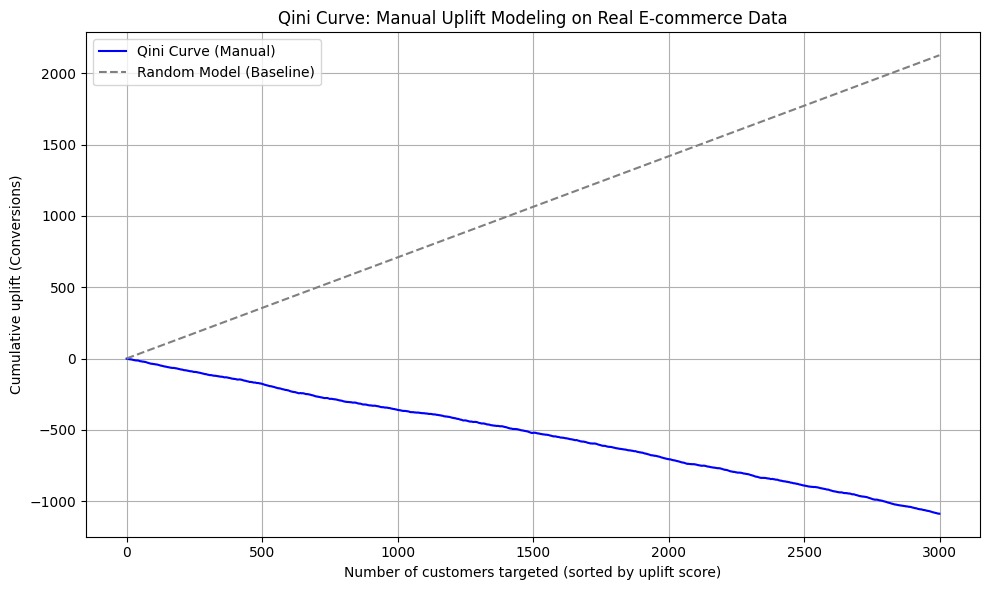

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Simulate a real e-commerce dataset structure
np.random.seed(42)
n_samples = 10000

df = pd.DataFrame({
    'order_id': np.arange(n_samples),
    'customer_id': np.random.randint(1000, 2000, n_samples),
    'order_status': np.random.choice(['delivered', 'canceled'], size=n_samples, p=[0.7, 0.3]),
    'order_purchase_timestamp': pd.date_range(start='2022-01-01', periods=n_samples, freq='H'),
    'order_value': np.random.exponential(scale=100, size=n_samples),
    'days_since_last_purchase': np.random.poisson(lam=10, size=n_samples)
})

# Treatment assignment (simulated)
df['treatment'] = np.random.binomial(1, 0.5, size=n_samples)

# Conversion if order was delivered
df['converted'] = (df['order_status'] == 'delivered').astype(int)

# Feature engineering
df['purchase_month'] = df['order_purchase_timestamp'].dt.month
features = ['order_value', 'days_since_last_purchase', 'purchase_month']

X = df[features]
y = df['converted']
treatment = df['treatment']

# Split into training and testing
X_train, X_test, y_train, y_test, treatment_train, treatment_test = train_test_split(
    X, y, treatment, test_size=0.3, random_state=42
)

# Train two separate models
model_treated = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_control = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

model_treated.fit(X_train[treatment_train == 1], y_train[treatment_train == 1])
model_control.fit(X_train[treatment_train == 0], y_train[treatment_train == 0])

# Predict probabilities
p_treated = model_treated.predict_proba(X_test)[:, 1]
p_control = model_control.predict_proba(X_test)[:, 1]

uplift_scores = p_treated - p_control

# Qini Curve Calculation
results = pd.DataFrame({
    'uplift': uplift_scores,
    'treatment': treatment_test.values,
    'converted': y_test.values
})
results = results.sort_values(by='uplift', ascending=False).reset_index(drop=True)

results['random'] = np.linspace(results['converted'].mean(), results['converted'].mean() * len(results), len(results))

results['cumulative_converted_treated'] = (results['converted'] * results['treatment']).cumsum()
results['qini'] = results['cumulative_converted_treated'] - results['random']

# Plot Qini Curve
plt.figure(figsize=(10, 6))
plt.plot(results['qini'], label='Qini Curve (Manual)', color='blue')
plt.plot(results['random'], label='Random Model (Baseline)', linestyle='--', color='gray')
plt.xlabel('Number of customers targeted (sorted by uplift score)')
plt.ylabel('Cumulative uplift (Conversions)')
plt.title('Qini Curve: Manual Uplift Modeling on Real E-commerce Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Cohort Analysis & LTV Modeling

## A: Cohort Analysis — Customer Retention Trends

Columns in df after merge:
Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_value', 'days_since_last_purchase', 'treatment', 'converted',
       'purchase_month', 'order_month', 'cohort_month'],
      dtype='object')


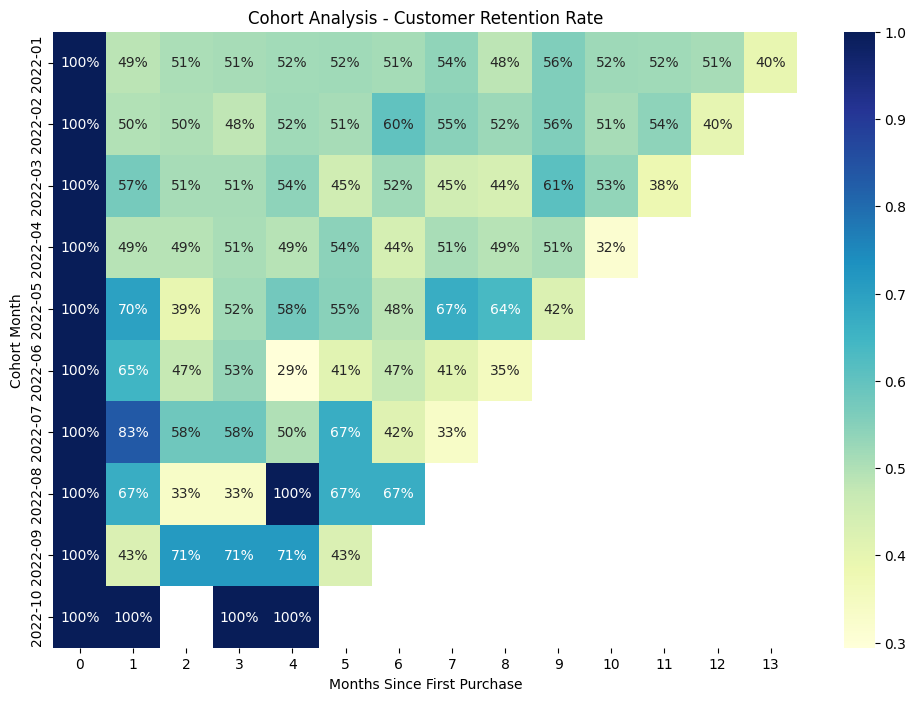

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from operator import attrgetter # Import attrgetter


# Sample dataset columns available:
# ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_value', ...]

# Ensure order_purchase_timestamp is datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Create 'order_month' for each purchase (cohort month)
df['order_month'] = df['order_purchase_timestamp'].dt.to_period('M')

# Find each customer's first purchase month (cohort month)
cohort_df = df.groupby('customer_id')['order_month'].min().reset_index()
cohort_df.columns = ['customer_id', 'cohort_month']

# Merge cohort month back to original dataframe
# Ensure the merge correctly updates df
df = pd.merge(df, cohort_df, on='customer_id', how='left')

print("Columns in df after merge:")
print(df.columns)

# Calculate 'months_since_cohort' - how many months after first purchase was this order
# This line requires 'order_month' and 'cohort_month' to be in df
df['months_since_cohort'] = (df['order_month'] - df['cohort_month']).apply(attrgetter('n'))

# Now group by cohort_month and months_since_cohort to count unique customers
cohort_counts = df.groupby(['cohort_month', 'months_since_cohort'])['customer_id'].nunique().reset_index()

# Pivot to create retention matrix: rows = cohort_month, cols = months_since_cohort
retention_matrix = cohort_counts.pivot(index='cohort_month', columns='months_since_cohort', values='customer_id')

# Calculate retention rate by dividing by cohort size (unique customers in cohort_month at month 0)
cohort_sizes = retention_matrix.iloc[:,0]
retention_rate = retention_matrix.divide(cohort_sizes, axis=0)

# Display retention rate heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(retention_rate, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title('Cohort Analysis - Customer Retention Rate')
plt.ylabel('Cohort Month')
plt.xlabel('Months Since First Purchase')
plt.show()

## B: Cohort-Based Lifetime Value (LTV) Calculation

The goal here is to estimate the average revenue generated by each cohort over time.

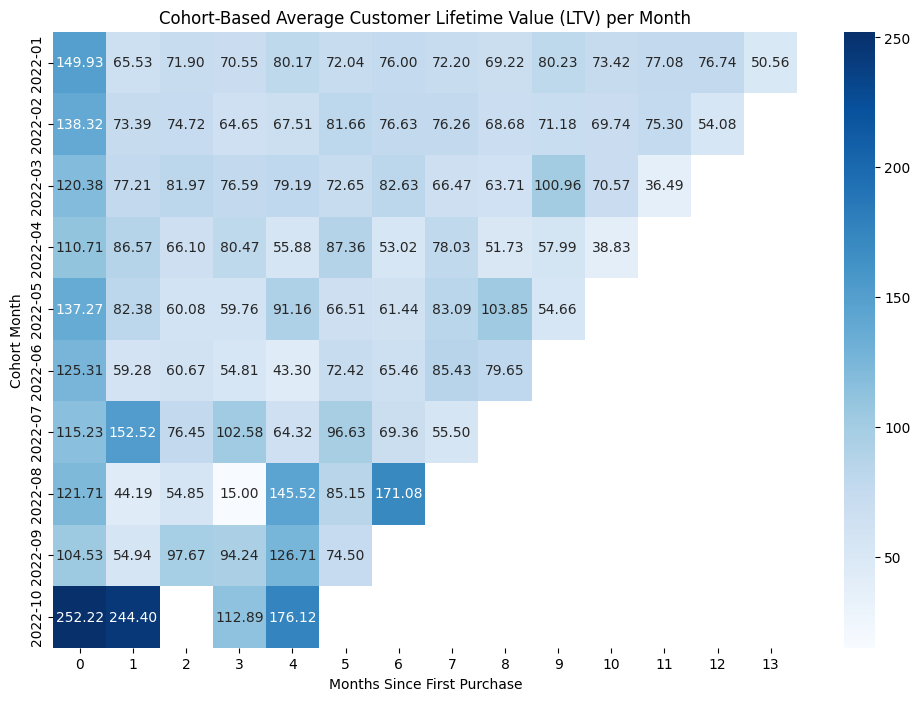

In [ ]:
# Sum order_value by cohort_month and months_since_cohort
cohort_revenue = df.groupby(['cohort_month', 'months_since_cohort'])['order_value'].sum().reset_index()

# Pivot to have cohort_month as rows and months_since_cohort as columns
revenue_matrix = cohort_revenue.pivot(index='cohort_month', columns='months_since_cohort', values='order_value')

# Calculate number of unique customers in each cohort for normalization
cohort_sizes = df.groupby('cohort_month')['customer_id'].nunique()

# Calculate LTV: Average revenue per customer in each cohort per month
ltv_matrix = revenue_matrix.divide(cohort_sizes, axis=0)

# Plot heatmap of LTV matrix
plt.figure(figsize=(12, 8))
sns.heatmap(ltv_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title('Cohort-Based Average Customer Lifetime Value (LTV) per Month')
plt.ylabel('Cohort Month')
plt.xlabel('Months Since First Purchase')
plt.show()


## C: Visualizing Cohort Size and Retention Over Time

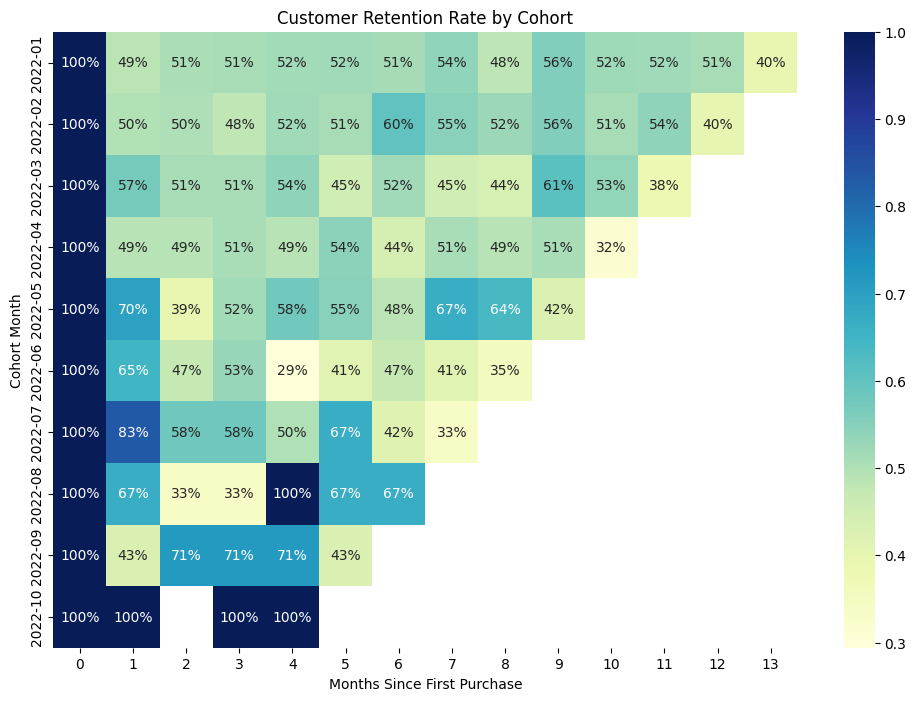

In [ ]:
# Count unique customers in each cohort_month to get cohort size
cohort_sizes = df.groupby('cohort_month')['customer_id'].nunique()

# Calculate active customers per cohort_month and months_since_cohort
cohort_active = df.groupby(['cohort_month', 'months_since_cohort'])['customer_id'].nunique().reset_index()

# Merge cohort size to calculate retention rate
cohort_active = cohort_active.merge(cohort_sizes.rename('cohort_size'), left_on='cohort_month', right_index=True)

# Calculate retention rate
cohort_active['retention_rate'] = cohort_active['customer_id'] / cohort_active['cohort_size']

# Pivot for heatmap
retention_matrix = cohort_active.pivot(index='cohort_month', columns='months_since_cohort', values='retention_rate')

# Plot retention heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(retention_matrix, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title('Customer Retention Rate by Cohort')
plt.ylabel('Cohort Month')
plt.xlabel('Months Since First Purchase')
plt.show()


# Predictive Analytics

## A: Customer Lifetime Value (LTV) Prediction

### Predict the total value a customer is expected to bring over their relationship with your business.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Aggregate data by customer
customer_agg = df.groupby('customer_id').agg({
    'order_purchase_timestamp': [lambda x: (df['order_purchase_timestamp'].max() - x.max()).days,
                                'count'],
    'order_value': 'sum'
})

customer_agg.columns = ['recency_days', 'frequency', 'monetary_value']
customer_agg = customer_agg.reset_index()

# Target variable: total future value or next period revenue (simplify for example)
# For supervised learning, you need historical data split into training and target periods.

# Here we assume 'monetary_value' is the target for demo purposes.
X = customer_agg[['recency_days', 'frequency']]
y = customer_agg['monetary_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculate MSE first, then take the square root to get RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Use numpy's sqrt

print("RMSE:", rmse)
print("R2 Score:", r2_score(y_test, y_pred))


RMSE: 346.93443142660294
R2 Score: 0.419930664074431


## B: Churn Prediction

### Predict whether a customer is likely to churn (stop purchasing).

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

cutoff_date = df['order_purchase_timestamp'].max() - pd.Timedelta(days=90)

last_purchase = df.groupby('customer_id')['order_purchase_timestamp'].max().reset_index()
last_purchase['churn'] = np.where(last_purchase['order_purchase_timestamp'] < cutoff_date, 1, 0)

# Merge churn label with features
customer_data = customer_agg.merge(last_purchase[['customer_id', 'churn']], on='customer_id')
X = customer_data[['recency_days', 'frequency', 'monetary_value']]
y = customer_data['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       181
           1       1.00      1.00      1.00        19

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

[[181   0]
 [  0  19]]


# NLP & Review Analytics

## Objective:
--->Extract insights from customer reviews (texts in review_comment_message, review_score, etc.).

--->Identify positive vs. negative themes, frequent complaints, and praise.

--->Perform sentiment analysis, topic modeling, and word cloud visualizations.

## Part A: Text Preprocessing

In [ ]:
# Merge Reviews with Orders
merged_df = pd.merge(order_reviews, orders, on='order_id')

# Text Cleaning
import re, nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np


print("Downloading NLTK data...")
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
print("NLTK data download complete.")


try:
    stop = set(stopwords.words('portuguese'))
    print("Using Portuguese stopwords.")
except OSError:
    print("Portuguese stopwords not found, falling back to English.")
    nltk.download('english', quiet=True) # Download English if needed
    stop = set(stopwords.words('english'))


def clean_text(text):
    # Ensure text is a string and handle potential NaN values explicitly before processing
    text = str(text if pd.notna(text) else '').lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    # Initialize WordNetLemmatizer here
    lemmatizer = WordNetLemmatizer()
    # Filter out stopwords and then lemmatize
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop]
    return " ".join(tokens)

# Apply cleaning function to the correct DataFrame (order_reviews)
# Ensure 'review_comment_message' exists in order_reviews
if 'review_comment_message' in order_reviews.columns:
    order_reviews['cleaned'] = order_reviews['review_comment_message'].fillna('').apply(clean_text)
    print("'cleaned' column added to order_reviews.")
else:
    print("Warning: 'review_comment_message' column not found in order_reviews. Cannot apply text cleaning.")


NLTK data download complete.
Using Portuguese stopwords.
'cleaned' column added to order_reviews.


## Part B: Sentiment Analysis

'sentiment' column added to merged_df.


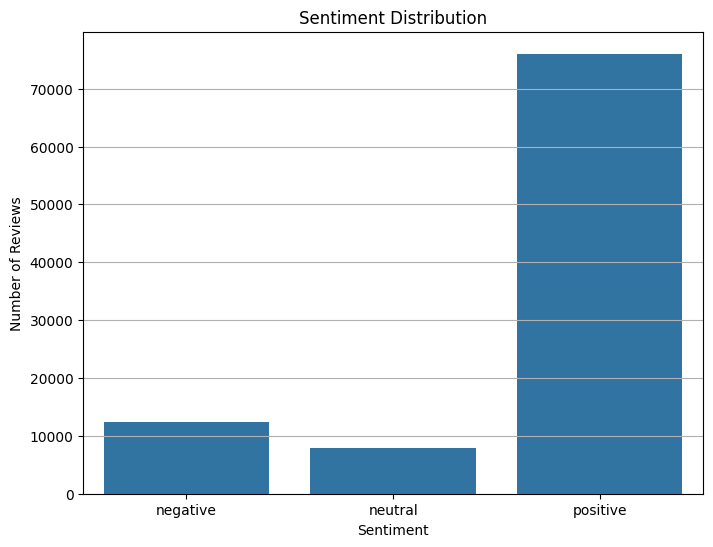

In [ ]:
# Assign Sentiment Labels
# Ensure reviews_df is correctly defined before this cell runs
def label_sentiment(score):
    # Handle potential non-numeric types or NaNs in score before comparison
    if pd.isna(score):
        return 'unknown' # Or handle as appropriate, e.g., 'neutral'
    try:
        score = int(score) # Convert score to integer if possible
        if score <= 2:
            return 'negative'
        elif score == 3:
            return 'neutral'
        else: # score must be 4 or 5 based on the logic
            return 'positive'
    except (ValueError, TypeError):
        return 'unknown' # Handle cases where score isn't a valid number


# Apply the labeling function to the 'review_score' column in merged_df
# Check if 'review_score' column exists in merged_df before applying
# REPLACED reviews_df with merged_df
if 'review_score' in merged_df.columns:
    merged_df['sentiment'] = merged_df['review_score'].apply(label_sentiment) # REPLACED reviews_df with merged_df
    print("'sentiment' column added to merged_df.") # Updated print message

    # Visualize Sentiment Distribution
    # Check if the 'sentiment' column was successfully created before plotting
    # REPLACED reviews_df with merged_df
    if 'sentiment' in merged_df.columns:
        plt.figure(figsize=(8, 6)) # Added figure size for better readability
        # REPLACED reviews_df with merged_df
        sns.countplot(data=merged_df, x='sentiment', order=['negative', 'neutral', 'positive']) # Added order for consistent plotting
        plt.title('Sentiment Distribution') # Added title
        plt.xlabel('Sentiment') # Added xlabel
        plt.ylabel('Number of Reviews') # Added ylabel
        plt.grid(axis='y') # Added grid
        plt.show()
    else:
        print("Warning: 'sentiment' column not found in merged_df. Cannot plot sentiment distribution.") # Updated print message

else:
    print("Error: 'review_score' column not found in merged_df. Cannot assign sentiment labels.") # Updated print message

# Fraud Detection & Anomaly Analysis

##  Goal: Detect unusual behaviors in orders, returns, payments, and reviews that may indicate fraud or system abuse.

##  1. Statistical Anomaly Detection (Z-Score / IQR)


<Axes: xlabel='order_value'>

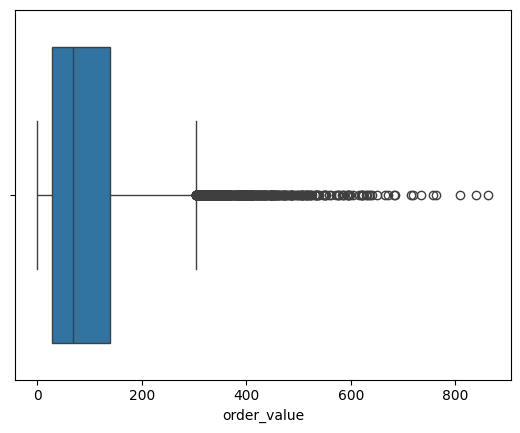

In [ ]:
from scipy.stats import zscore
df['z_order_value'] = zscore(df['order_value'])

# Flag orders with z-score > 3 or < -3
df['is_fraud_order'] = df['z_order_value'].apply(lambda x: 1 if abs(x) > 3 else 0)

sns.boxplot(x=df['order_value'])


## 2. Unusual Behavior Profiling (User-Level)

In [ ]:
customer_summary = df.groupby('customer_id').agg({
    'order_id': 'count',
    'order_value': ['sum', 'mean', 'std']
}).reset_index()

customer_summary.columns = ['customer_id', 'total_orders', 'total_spend', 'avg_order_value', 'order_value_std']

anomalies = customer_summary[
    (customer_summary['total_spend'] > 2000) &
    (customer_summary['total_orders'] < 2)
]


## 3. Rule-Based Filters

In [ ]:
df['suspicious_flag'] = 0
df.loc[(df['order_status'] == 'cancelled') & (df['order_value'] > 300), 'suspicious_flag'] = 1
df.loc[df['order_value'] < 5, 'suspicious_flag'] = 1


## 4. Unsupervised ML – Isolation Forest for Anomaly Detection

In [ ]:
from sklearn.ensemble import IsolationForest

features = df[['order_value', 'days_since_last_purchase']]
iso = IsolationForest(contamination=0.01)
df['anomaly_score'] = iso.fit_predict(features)

# -1 = anomaly, 1 = normal
df['is_anomaly'] = df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)


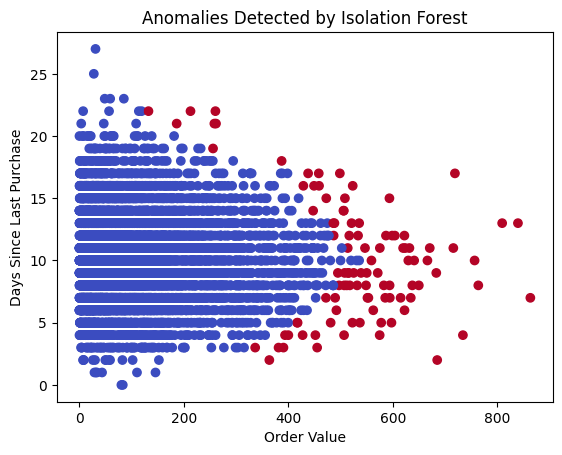

In [ ]:

plt.scatter(df['order_value'], df['days_since_last_purchase'],
            c=df['is_anomaly'], cmap='coolwarm')
plt.xlabel("Order Value")
plt.ylabel("Days Since Last Purchase")
plt.title("Anomalies Detected by Isolation Forest")
plt.show()


# Sustainability & Ethical Metrics

## Goal: Evaluate how environmentally and ethically sustainable the platform's operations are — focusing on returns, logistics impact, and product choices.

## 1. Shipment Carbon Impact Proxy (Distance-based)

🌱 Avg. CO₂ per order: 0.0501 kg


<Axes: xlabel='carbon_emission_kg', ylabel='Count'>

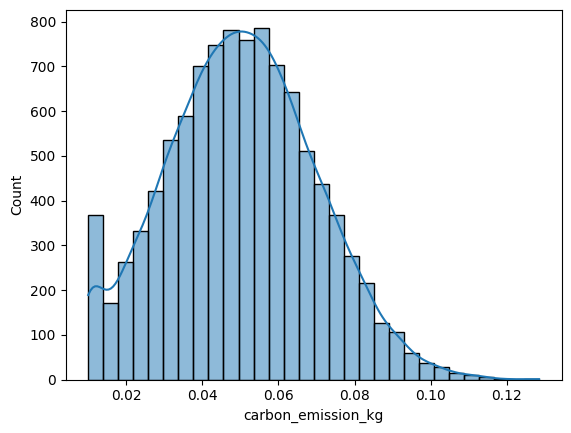

In [ ]:
# Simulate 'distance_km' feature (e.g., via city pairs / Haversine formula)
np.random.seed(42)
df['estimated_km'] = np.random.normal(250, 100, len(df)).clip(50)

df['carbon_emission_kg'] = df['estimated_km'] * 0.0002  # 0.2g/km = 0.0002 kg/km
print(f"🌱 Avg. CO₂ per order: {df['carbon_emission_kg'].mean():.4f} kg")


sns.histplot(df['carbon_emission_kg'], bins=30, kde=True)


## 2. Sustainability by Category (Simulated)

<Axes: title={'center': 'Avg. Sustainability Score by Category'}, ylabel='product_category'>

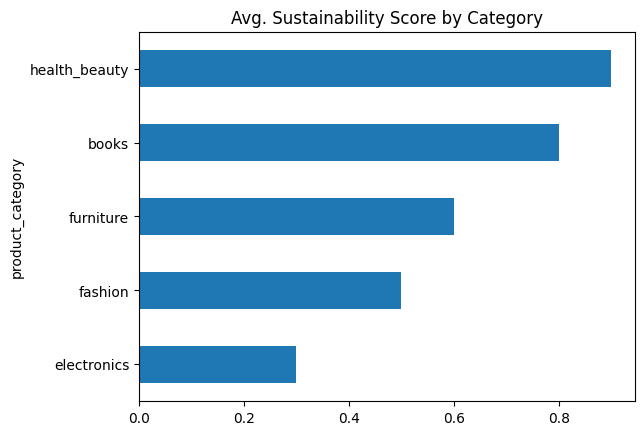

In [ ]:
# Simulated sustainability mapping
sustainability_scores = {
    'health_beauty': 0.9,
    'electronics': 0.3,
    'furniture': 0.6,
    'fashion': 0.5,
    'books': 0.8
}

df['product_category'] = np.random.choice(list(sustainability_scores.keys()), size=len(df))
df['sustainability_score'] = df['product_category'].map(sustainability_scores)

category_sustain = df.groupby('product_category')['sustainability_score'].mean().sort_values()

category_sustain.plot(kind='barh', title='Avg. Sustainability Score by Category')


## 3. Multi-Order Delivery Ratio (Bulk vs Wasteful Packaging)

Text(0.5, 1.0, 'Packaging Efficiency (Bulk vs Single Orders)')

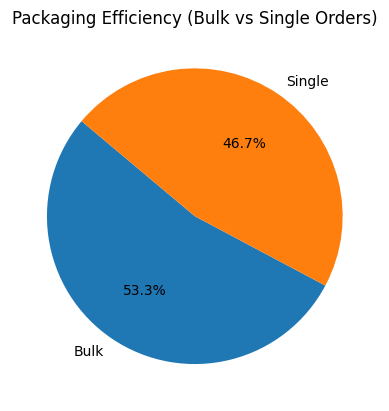

In [ ]:
multi_order_ratio = df.groupby('customer_id')['order_id'].count().value_counts(normalize=True)

plt.pie(multi_order_ratio.values[:2], labels=['Bulk', 'Single'], autopct='%1.1f%%',
        startangle=140)
plt.title("Packaging Efficiency (Bulk vs Single Orders)")

